<a href="https://colab.research.google.com/github/Ritviks21/Silicon-Sentinel/blob/main/Silicon_Sentinel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What to Do When You Return Tomorrow
You will need to rerun the notebook from the top to get back to where you were. Here is the recommended workflow:

Reconnect to the Colab session.

Re-install the libraries by running the !pip install cell.

Generate the "Ultimate" Dataset: Run the final data generation script (the one with curved scratches and hard particles) to create the ultimate_wafer_dataset.

Split the Data: Run the cell that splits the data into train, val, and test sets and creates the new data.yaml file.

Re-Train the Model: Run the final training cell. This will again take a considerable amount of time to complete the 50 epochs.

Re-upload and Unzip Test Images: You will need to upload your test_images.zip file again and run the unzip cell.

Run the Final Evaluation: Once training is done, you can run the evaluation cell to see the predictions from your newly trained model.

Crucial Tip for the Future: Mount Your Google Drive
To prevent losing your datasets and trained models in the future, you should save them directly to your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Install Libraries

This will install all the libraries we need for the entire project.

In [ ]:
 # Installs all necessary libraries:
# ultralytics: For the YOLOv8 model.
# opencv-python: For image processing (creating defects).
# numpy: For creating our image canvas and numerical operations.
!pip install ultralytics opencv-python numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Advanced Data Generation Script

What This Code Does
Creates Realistic Backgrounds: Instead of a plain background, it adds a faint grid, just like in your test images. This is a critical improvement.

Generates Diverse Scratches & Particles: It randomizes the angle, length, thickness, and color of every defect so the model can't just memorize one type.

Creates Irregular Blobs: This is the key upgrade. It creates complex, semi-transparent blobs by overlapping multiple circles and blending them. This will teach the model to recognize the exact type of defect it failed on before.

Builds the Dataset: It runs a loop to create 2,000 images and their corresponding label files, saving them into a robust_wafer_dataset folder.

In [ ]:
import os
import cv2
import numpy as np
import random

# --- Configuration ---
# This section sets up the main parameters for our dataset.
# We'll create 2000 images to give the model plenty of examples.
DATASET_PATH = 'robust_wafer_dataset'
NUM_IMAGES = 2000
IMG_WIDTH = 640
IMG_HEIGHT = 640

# --- Defect Class Mapping ---
# We define our defect types. We've added "blob" to match your test images.
# Each defect type is assigned a number (0, 1, 2) which YOLO uses.
defect_classes = {
    "scratch": 0,
    "particle": 1,
    "blob": 2,
}

# --- Main Generation Function ---
def generate_dataset():
    """
    This is the main function that orchestrates the entire dataset creation process.
    """
    # Create the main folder structure:
    # robust_wafer_dataset/
    #  |- images/
    #  |- labels/
    images_path = os.path.join(DATASET_PATH, 'images')
    labels_path = os.path.join(DATASET_PATH, 'labels')
    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)
    print(f"Directories created at: {os.path.abspath(DATASET_PATH)}")

    # Loop to create each image and its corresponding label file.
    for i in range(NUM_IMAGES):
        # Create a realistic wafer background.
        wafer_image = create_base_wafer()

        # This list will hold the annotations for all defects in this one image.
        annotations = []

        # Add a random number of different defects to the image.
        num_defects = random.randint(1, 4)
        for _ in range(num_defects):
            defect_type = random.choice(list(defect_classes.keys()))

            if defect_type == "scratch":
                wafer_image, ann = add_scratch(wafer_image)
            elif defect_type == "particle":
                wafer_image, ann = add_particle_cluster(wafer_image)
            elif defect_type == "blob":
                wafer_image, ann = add_blob(wafer_image)

            if ann: # Check if a defect was successfully added
                annotations.append(ann)

        # Save the final image with all its defects.
        img_name = f'wafer_{i:04d}.png'
        cv2.imwrite(os.path.join(images_path, img_name), wafer_image)

        # Save the annotations for this image to a .txt file.
        label_name = f'wafer_{i:04d}.txt'
        with open(os.path.join(labels_path, label_name), 'w') as f:
            for ann in annotations:
                # Format: class_id x_center y_center width height
                f.write(f"{ann[0]} {ann[1]} {ann[2]} {ann[3]} {ann[4]}\n")

        if (i + 1) % 200 == 0:
            print(f"  -> Generated {i + 1}/{NUM_IMAGES} images...")

    print(f"\n✅ Dataset generation complete!")

# --- Helper Functions to Create Defects ---

def create_base_wafer():
    """
    Creates a more realistic wafer background by adding a grid and noise.
    This prevents the model from overfitting to a simple, plain background.
    """
    # Create a dark gray canvas
    image = np.full((IMG_HEIGHT, IMG_WIDTH, 3), (50, 50, 50), dtype=np.uint8)
    # Add a faint grid, similar to your test images
    for x in range(0, IMG_WIDTH, 50):
        cv2.line(image, (x, 0), (x, IMG_HEIGHT), (60, 60, 60), 1)
    for y in range(0, IMG_HEIGHT, 50):
        cv2.line(image, (0, y), (IMG_WIDTH, y), (60, 60, 60), 1)
    return image

def add_scratch(image):
    """
    Adds a scratch with randomized properties (angle, length, thickness, color).
    This teaches the model what a "general" scratch looks like.
    """
    start_x = random.randint(20, IMG_WIDTH - 20)
    start_y = random.randint(20, IMG_HEIGHT - 20)
    end_x = start_x + random.randint(-200, 200)
    end_y = start_y + random.randint(-200, 200)
    thickness = random.randint(1, 3)
    color = (random.randint(200, 255),) * 3
    cv2.line(image, (start_x, start_y), (end_x, end_y), color, thickness)

    # Calculate bounding box in YOLO format
    x_min, x_max = sorted((start_x, end_x))
    y_min, y_max = sorted((start_y, end_y))
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    return image, [defect_classes["scratch"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_particle_cluster(image):
    """
    Adds a cluster of small particles, which is more realistic than single dots.
    """
    center_x = random.randint(50, IMG_WIDTH - 50)
    center_y = random.randint(50, IMG_HEIGHT - 50)
    num_particles = random.randint(3, 10)

    all_x, all_y = [], []
    for _ in range(num_particles):
        px = center_x + random.randint(-40, 40)
        py = center_y + random.randint(-40, 40)
        radius = random.randint(1, 3)
        color = (random.randint(200, 255),) * 3
        cv2.circle(image, (px, py), radius, color, -1)
        all_x.extend([px - radius, px + radius])
        all_y.extend([py - radius, py + radius])

    # Calculate a single bounding box for the whole cluster
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    return image, [defect_classes["particle"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_blob(image):
    """
    This is the most important new function. It creates irregular, semi-transparent
    blobs just like the one your old model failed to detect.
    """
    overlay = image.copy()
    output = image.copy()

    center_x = random.randint(100, IMG_WIDTH - 100)
    center_y = random.randint(100, IMG_HEIGHT - 100)

    # Blobs are made of multiple overlapping circles to create an irregular shape
    num_circles = random.randint(2, 5)
    all_x, all_y = [], []
    for _ in range(num_circles):
        radius = random.randint(20, 50)
        cx = center_x + random.randint(-30, 30)
        cy = center_y + random.randint(-30, 30)
        color = (random.randint(80, 120),) * 3 # Blobs are darker gray
        cv2.circle(overlay, (cx, cy), radius, color, -1)
        all_x.extend([cx - radius, cx + radius])
        all_y.extend([cy - radius, cy + radius])

    # Blend the blob layer with the wafer image to make it semi-transparent
    transparency = random.uniform(0.3, 0.7)
    cv2.addWeighted(overlay, transparency, output, 1 - transparency, 0, image)

    # Calculate bounding box for the whole blob
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    return image, [defect_classes["blob"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]


# --- Execute the Generation ---
generate_dataset()

Directories created at: /content/robust_wafer_dataset
  -> Generated 200/2000 images...
  -> Generated 400/2000 images...
  -> Generated 600/2000 images...
  -> Generated 800/2000 images...
  -> Generated 1000/2000 images...
  -> Generated 1200/2000 images...
  -> Generated 1400/2000 images...
  -> Generated 1600/2000 images...
  -> Generated 1800/2000 images...
  -> Generated 2000/2000 images...

✅ Dataset generation complete!


Organize Data and Create

Split Data and Create YAML

Shuffles Data: It randomly shuffles all 2,000 images to ensure that our training, validation, and test sets are all equally representative of the overall data.

Creates New Folders: It creates a new main directory called wafer_data_for_training with the standard train, val, and test subdirectories inside.

Copies Files: It copies the correct image and label files from your robust_wafer_dataset folder into the appropriate train/val/test folders.

Generates data.yaml: It creates the critical data.yaml file inside wafer_data_for_training. This file points the YOLO model to the correct folders and defines our three defect classes: scratch, particle, and blob.

In [ ]:
import os
import random
import shutil

# --- Configuration ---
# This section defines the source of our data and how we want to split it.
DATA_SOURCE_DIR = 'robust_wafer_dataset'
OUTPUT_DIR = 'wafer_data_for_training'
TRAIN_RATIO = 0.7  # 70% of data for training
VAL_RATIO = 0.2   # 20% for validation
# The remaining 10% will automatically be used for testing.

# --- Main Splitting Function ---
def split_dataset():
    """
    This function splits the generated dataset into train, validation,
    and test sets, and creates the necessary data.yaml file for YOLO.
    """
    # Get a list of all the image files we generated.
    images_source_path = os.path.join(DATA_SOURCE_DIR, 'images')
    all_images = [f for f in os.listdir(images_source_path) if f.endswith('.png')]
    random.shuffle(all_images) # Shuffle the list to ensure random distribution.

    # Calculate how many images go into each set.
    total_images = len(all_images)
    train_end = int(total_images * TRAIN_RATIO)
    val_end = train_end + int(total_images * VAL_RATIO)

    # Create the lists of files for each set.
    train_files = all_images[:train_end]
    val_files = all_images[train_end:val_end]
    test_files = all_images[val_end:]

    # Clean up any old directories before starting.
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)

    # Copy the files into their new homes: train, val, and test folders.
    copy_files(train_files, 'train')
    copy_files(val_files, 'val')
    copy_files(test_files, 'test')

    # Create the data.yaml file.
    create_yaml_file()

    print(f"\n✅ Dataset successfully split into train, val, test sets.")
    print(f"✅ 'data.yaml' created at '{os.path.join(OUTPUT_DIR, 'data.yaml')}'")

# --- Helper function to copy files ---
def copy_files(file_list, set_name):
    """
    Copies image and label files from the source to the destination folder (train/val/test).
    """
    # Define paths for images and labels for the given set (e.g., 'wafer_data_for_training/train/images')
    dest_images_path = os.path.join(OUTPUT_DIR, set_name, 'images')
    dest_labels_path = os.path.join(OUTPUT_DIR, set_name, 'labels')
    os.makedirs(dest_images_path, exist_ok=True)
    os.makedirs(dest_labels_path, exist_ok=True)

    source_images_path = os.path.join(DATA_SOURCE_DIR, 'images')
    source_labels_path = os.path.join(DATA_SOURCE_DIR, 'labels')

    for filename in file_list:
        base_name = os.path.splitext(filename)[0]
        # Copy image file
        shutil.copy(os.path.join(source_images_path, filename), os.path.join(dest_images_path, filename))
        # Copy corresponding label file
        shutil.copy(os.path.join(source_labels_path, f'{base_name}.txt'), os.path.join(dest_labels_path, f'{base_name}.txt'))

    print(f"  -> Copied {len(file_list)} images and labels to '{set_name}' set.")

# --- Helper function to create the YAML file ---
def create_yaml_file():
    """
    Creates the data.yaml file that YOLO needs to understand our dataset structure.
    """
    # The content of the YAML file. It tells YOLO the path to the data,
    # the location of train/val/test sets, the number of classes, and their names.
    yaml_content = f"""
path: {os.path.abspath(OUTPUT_DIR)}
train: train/images
val: val/images
test: test/images

nc: 3
names: ['scratch', 'particle', 'blob']
"""
    with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w') as f:
        f.write(yaml_content)

# --- Execute the Splitting ---
split_dataset()

  -> Copied 1400 images and labels to 'train' set.
  -> Copied 400 images and labels to 'val' set.
  -> Copied 200 images and labels to 'test' set.

✅ Dataset successfully split into train, val, test sets.
✅ 'data.yaml' created at 'wafer_data_for_training/data.yaml'


Train the Model

A summary of the model architecture will be printed.

The training process will start, showing a progress bar for each epoch (from 1 to 50).

You will see metrics like precision, recall, and mAP updating after each epoch. These numbers tell us how well the model is learning. We want to see them go up!

In [ ]:
from ultralytics import YOLO

# --- Model Training ---
def train_model():
    """
    This function initializes and trains the YOLOv8 model on our prepared dataset.
    """
    # 1. Load a pre-trained model.
    # We use 'yolov8n.pt', which is the smallest and fastest version of YOLOv8.
    # This is called Transfer Learning: the model already knows how to see basic
    # shapes and textures. We just need to teach it to find our specific defects.
    # This makes training MUCH faster and more effective.
    model = YOLO('yolov8n.pt')

    # 2. Start the training process.
    # We point the model to our 'data.yaml' file, which contains all the
    # information about our dataset.
    print("🚀 Starting model training...")
    results = model.train(
        data='wafer_data_for_training/data.yaml',
        epochs=50,  # The model will go through the entire dataset 50 times.
        imgsz=640,  # We tell the model our images are 640x640 pixels.
        project='wafer_defect_runs', # A folder to save all training results.
        name='robust_model_v1'      # A specific name for this training run.
    )
    print("✅ Training complete!")
    print(f"Results saved to: {results.save_dir}")

# --- Execute the Training ---
train_model()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.6MB/s]


🚀 Starting model training...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=wafer_data_for_training/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=robust_model_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspe

100%|██████████| 755k/755k [00:00<00:00, 15.2MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 61.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 546.8±203.6 MB/s, size: 26.5 KB)


train: Scanning /content/wafer_data_for_training/train/labels... 1400 images, 0 backgrounds, 117 corrupt: 100%|██████████| 1400/1400 [00:00<00:00, 1999.11it/s]

train: /content/wafer_data_for_training/train/images/wafer_0051.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0367]
train: /content/wafer_data_for_training/train/images/wafer_0060.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0625]
train: /content/wafer_data_for_training/train/images/wafer_0083.png: ignoring corrupt image/label: negative class labels [  -0.060938]
train: /content/wafer_data_for_training/train/images/wafer_0153.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0969]
train: /content/wafer_data_for_training/train/images/wafer_0172.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.068]
train: /content/wafer_data_for_training/train/images/wafer_0192.png: ignoring corrupt image/label: negative class labels [  -0.014062]
train: /content/wafer_data_for_training/train/images/wafer_0198.png: ignoring corrupt image/label: neg

train: New cache created: /content/wafer_data_for_training/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 474.7±269.2 MB/s, size: 26.1 KB)


val: Scanning /content/wafer_data_for_training/val/labels... 400 images, 0 backgrounds, 28 corrupt: 100%|██████████| 400/400 [00:00<00:00, 1192.47it/s]

val: /content/wafer_data_for_training/val/images/wafer_0104.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0297]
val: /content/wafer_data_for_training/val/images/wafer_0106.png: ignoring corrupt image/label: negative class labels [  -0.032031]
val: /content/wafer_data_for_training/val/images/wafer_0165.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.043]
val: /content/wafer_data_for_training/val/images/wafer_0186.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0211]
val: /content/wafer_data_for_training/val/images/wafer_0258.png: ignoring corrupt image/label: negative class labels [  -0.019531]
val: /content/wafer_data_for_training/val/images/wafer_0268.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1047]
val: /content/wafer_data_for_training/val/images/wafer_0368.png: ignoring corrupt image/label: non-normalized or out of bounds

Plotting labels to wafer_defect_runs/robust_model_v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to wafer_defect_runs/robust_model_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.09G      1.015      2.057      1.098         14        640: 100%|██████████| 81/81 [00:27<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]

                   all        372        877      0.949      0.229      0.756        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.57G     0.7933      1.122      1.009          6        640: 100%|██████████| 81/81 [00:25<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.97it/s]

                   all        372        877      0.867      0.838      0.888      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.58G      0.781     0.9672      1.015         10        640: 100%|██████████| 81/81 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]


                   all        372        877      0.849      0.875      0.898      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.61G     0.7334     0.8317     0.9981         14        640: 100%|██████████| 81/81 [00:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

                   all        372        877      0.895      0.845      0.907      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.62G     0.7111     0.7428     0.9966         17        640: 100%|██████████| 81/81 [00:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]

                   all        372        877      0.886      0.884      0.907      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.64G     0.6787      0.689     0.9794         11        640: 100%|██████████| 81/81 [00:24<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]

                   all        372        877      0.902      0.889      0.931      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.65G     0.6539     0.6296     0.9719          8        640: 100%|██████████| 81/81 [00:24<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.22it/s]

                   all        372        877      0.921      0.883      0.933      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.67G      0.649     0.6062      0.976          9        640: 100%|██████████| 81/81 [00:24<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.23it/s]

                   all        372        877      0.922      0.891      0.929      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.69G     0.6185     0.5768     0.9609         15        640: 100%|██████████| 81/81 [00:25<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.98it/s]

                   all        372        877      0.935      0.879      0.933      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.71G      0.602     0.5482     0.9531         11        640: 100%|██████████| 81/81 [00:24<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

                   all        372        877      0.936      0.913      0.942      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.71G     0.5904     0.5331     0.9574          7        640: 100%|██████████| 81/81 [00:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

                   all        372        877      0.934      0.918      0.948      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.74G     0.5815     0.5225     0.9512          8        640: 100%|██████████| 81/81 [00:24<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.29it/s]

                   all        372        877      0.921      0.915      0.941      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.76G     0.5762     0.5149      0.946          7        640: 100%|██████████| 81/81 [00:25<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.24it/s]

                   all        372        877       0.94      0.913      0.955      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.78G      0.568     0.5082      0.941          9        640: 100%|██████████| 81/81 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]

                   all        372        877      0.934      0.901      0.943      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.79G     0.5658      0.507     0.9485         18        640: 100%|██████████| 81/81 [00:24<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]

                   all        372        877       0.94      0.926      0.948       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.81G     0.5322     0.4721     0.9336         12        640: 100%|██████████| 81/81 [00:24<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.33it/s]

                   all        372        877      0.927      0.928      0.956      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.83G     0.5201     0.4602     0.9313         11        640: 100%|██████████| 81/81 [00:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]

                   all        372        877      0.935      0.908       0.95      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.84G     0.5302     0.4739     0.9434          8        640: 100%|██████████| 81/81 [00:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]


                   all        372        877      0.943      0.891      0.945      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.85G     0.5193     0.4614     0.9361         15        640: 100%|██████████| 81/81 [00:24<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]

                   all        372        877      0.955      0.901       0.96      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.88G     0.5228     0.4501     0.9276         12        640: 100%|██████████| 81/81 [00:22<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.57it/s]

                   all        372        877      0.945      0.937      0.961      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.9G     0.5146     0.4551     0.9216          8        640: 100%|██████████| 81/81 [00:24<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]

                   all        372        877      0.947      0.922      0.957      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.91G     0.5183      0.456     0.9317         12        640: 100%|██████████| 81/81 [00:24<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        372        877      0.965      0.928      0.964      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.92G     0.5179     0.4456     0.9253         14        640: 100%|██████████| 81/81 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.33it/s]

                   all        372        877       0.93      0.928      0.962      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.95G     0.4956     0.4339     0.9244         12        640: 100%|██████████| 81/81 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.89it/s]

                   all        372        877      0.956      0.932      0.962      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.96G     0.4998     0.4451     0.9279          8        640: 100%|██████████| 81/81 [00:23<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


                   all        372        877      0.954       0.91      0.959       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.98G     0.4885     0.4256     0.9221          5        640: 100%|██████████| 81/81 [00:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        372        877      0.951      0.941       0.97       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.99G     0.4979     0.4413     0.9261         13        640: 100%|██████████| 81/81 [00:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

                   all        372        877      0.949      0.931      0.961      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.02G     0.4692     0.4159     0.9078         10        640: 100%|██████████| 81/81 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        372        877      0.947      0.939      0.964      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.03G     0.4692     0.4243     0.9085         12        640: 100%|██████████| 81/81 [00:24<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]

                   all        372        877      0.966      0.918      0.967      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.05G      0.471     0.4138     0.9118          6        640: 100%|██████████| 81/81 [00:23<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        372        877      0.935      0.948       0.97      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.06G     0.4665     0.4091     0.9229         16        640: 100%|██████████| 81/81 [00:23<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.11it/s]

                   all        372        877      0.954      0.915      0.965      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.08G     0.4588     0.4003     0.9108          8        640: 100%|██████████| 81/81 [00:24<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]

                   all        372        877      0.941      0.939      0.967      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       3.1G       0.47      0.416      0.919         11        640: 100%|██████████| 81/81 [00:24<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

                   all        372        877      0.952      0.936      0.971      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.12G     0.4492     0.4057     0.9066         10        640: 100%|██████████| 81/81 [00:24<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

                   all        372        877       0.96      0.932      0.968      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.12G     0.4575     0.3934     0.9159         12        640: 100%|██████████| 81/81 [00:24<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]

                   all        372        877      0.944      0.934       0.97      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.15G     0.4392     0.3872      0.903          5        640: 100%|██████████| 81/81 [00:24<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.93it/s]

                   all        372        877      0.955      0.936       0.97      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.17G     0.4221     0.3739     0.8892         14        640: 100%|██████████| 81/81 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

                   all        372        877      0.945      0.919      0.964      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.19G     0.4287      0.374     0.8969         19        640: 100%|██████████| 81/81 [00:24<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.42it/s]

                   all        372        877      0.964      0.918      0.972       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.19G     0.4243     0.3843     0.8943         16        640: 100%|██████████| 81/81 [00:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.22it/s]


                   all        372        877      0.949      0.927      0.969      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.22G     0.4255     0.3784      0.896         16        640: 100%|██████████| 81/81 [00:25<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]


                   all        372        877      0.963      0.936      0.974      0.914
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.24G     0.3174     0.2861     0.8381          8        640: 100%|██████████| 81/81 [00:25<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.31it/s]


                   all        372        877      0.966      0.926      0.974      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.25G     0.3148     0.2809     0.8305          5        640: 100%|██████████| 81/81 [00:23<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

                   all        372        877      0.971      0.924      0.973      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.26G     0.3056     0.2701      0.836         10        640: 100%|██████████| 81/81 [00:24<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]


                   all        372        877      0.938      0.956      0.975      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.29G     0.3114     0.2795     0.8373          5        640: 100%|██████████| 81/81 [00:24<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.29it/s]

                   all        372        877      0.963      0.933      0.975      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       3.3G      0.294      0.275     0.8278          5        640: 100%|██████████| 81/81 [00:23<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        372        877      0.956      0.952      0.977      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.32G     0.3006     0.2713     0.8361          4        640: 100%|██████████| 81/81 [00:22<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


                   all        372        877      0.955      0.956      0.976      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.33G     0.2881     0.2653     0.8311          5        640: 100%|██████████| 81/81 [00:23<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]

                   all        372        877       0.95      0.953      0.976      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.36G     0.2895     0.2645     0.8356         10        640: 100%|██████████| 81/81 [00:24<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        372        877      0.969      0.937      0.976      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.37G     0.2824     0.2592     0.8275          7        640: 100%|██████████| 81/81 [00:24<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        372        877      0.954      0.953      0.977      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.39G     0.2785     0.2523     0.8233          7        640: 100%|██████████| 81/81 [00:24<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]


                   all        372        877      0.953      0.959      0.978      0.926

50 epochs completed in 0.404 hours.
Optimizer stripped from wafer_defect_runs/robust_model_v1/weights/last.pt, 6.2MB
Optimizer stripped from wafer_defect_runs/robust_model_v1/weights/best.pt, 6.2MB

Validating wafer_defect_runs/robust_model_v1/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


                   all        372        877      0.954      0.953      0.977      0.928
               scratch        212        269      0.913      0.892      0.946      0.836
              particle        223        314      0.976      0.981      0.993      0.968
                  blob        201        294      0.973      0.986      0.993       0.98
Speed: 0.4ms preprocess, 2.5ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to wafer_defect_runs/robust_model_v1
✅ Training complete!
Results saved to: wafer_defect_runs/robust_model_v1


Evaluate the New Model

Unzips Test Data: It safely unzips your test_images.zip file.

Loads Your Best Model: It loads the best.pt file from the training run we just completed.

Runs Prediction: It runs the model on every image inside your test folder.

Displays Results: It finds the output images with the defect boxes drawn on them and displays them one by one, right here in Colab.

In [ ]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- Model and Data Configuration ---
def evaluate_model():
    """
    This function loads our newly trained model and runs it on the
    challenging test images to verify its performance.
    """
    # 1. Unzip the test images you just uploaded.
    # We use a 'try-except' block to avoid errors if the file is already unzipped.
    try:
        if os.path.exists('test_images.zip'):
            print("Unzipping test images...")
            os.system('unzip -o test_images.zip -d test_images_unzipped') # -o overwrites without asking
            print("✅ Unzip complete.")
        else:
            print("️️️⚠️ 'test_images.zip' not found. Please upload it first.")
            return
    except Exception as e:
        print(f"Error during unzip: {e}")
        return

    # 2. Define the path to our best trained model.
    # This is the "brain" we just created.
    model_path = 'wafer_defect_runs/robust_model_v1/weights/best.pt'

    # 3. Define the folder containing the test images.
    test_images_folder = 'test_images_unzipped/test_images'

    # Check if the model and images exist before proceeding.
    if not os.path.exists(model_path):
        print(f"❌ ERROR: Model not found at {model_path}")
        return
    if not os.path.exists(test_images_folder):
        print(f"❌ ERROR: Test images folder not found at {test_images_folder}")
        return

    # 4. Load our powerful, fine-tuned model.
    print(f"\nLoading model from: {model_path}")
    model = YOLO(model_path)
    print("✅ Model loaded successfully.")

    # 5. Run prediction on all images in the test folder.
    # The results will be saved to a new folder.
    print("\n🚀 Running predictions on test images...")
    results = model.predict(source=test_images_folder, save=True)
    print("✅ Predictions complete!")

    # 6. Display the results.
    # We will find the output images with the bounding boxes drawn on them
    # and display them directly in our Colab notebook.
    print("\n--- Displaying Results ---")
    prediction_output_dir = results[0].save_dir
    result_images = glob.glob(os.path.join(prediction_output_dir, '*.png'))

    if not result_images:
        print("Could not find any result images to display.")
    else:
        for img_path in sorted(result_images):
            print(f"\nDisplaying: {os.path.basename(img_path)}")
            display(Image(filename=img_path))

# --- Execute the Evaluation ---
evaluate_model()

Unzipping test images...
✅ Unzip complete.

Loading model from: wafer_defect_runs/robust_model_v1/weights/best.pt
✅ Model loaded successfully.

🚀 Running predictions on test images...

image 1/5 /content/test_images_unzipped/test_images/wafer_all_defects.png: 640x640 3 scratchs, 4 particles, 1 blob, 9.3ms
image 2/5 /content/test_images_unzipped/test_images/wafer_blob.png: 640x640 4 scratchs, 1 blob, 14.6ms
image 3/5 /content/test_images_unzipped/test_images/wafer_clean.png: 640x640 4 scratchs, 8.2ms
image 4/5 /content/test_images_unzipped/test_images/wafer_particles.png: 640x640 3 scratchs, 4 particles, 7.4ms
image 5/5 /content/test_images_unzipped/test_images/wafer_scratch.png: 640x640 4 scratchs, 7.4ms
Speed: 4.4ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
✅ Predictions complete!

--- Displaying Results ---
Could not find any result images to display.


Display Prediction Images

✅ Found 5 images in the folder.
List of files found: ['runs/detect/predict/wafer_all_defects.jpg', 'runs/detect/predict/wafer_blob.jpg', 'runs/detect/predict/wafer_clean.jpg', 'runs/detect/predict/wafer_particles.jpg', 'runs/detect/predict/wafer_scratch.jpg']

--- Displaying All Results ---

Result for: wafer_all_defects.jpg


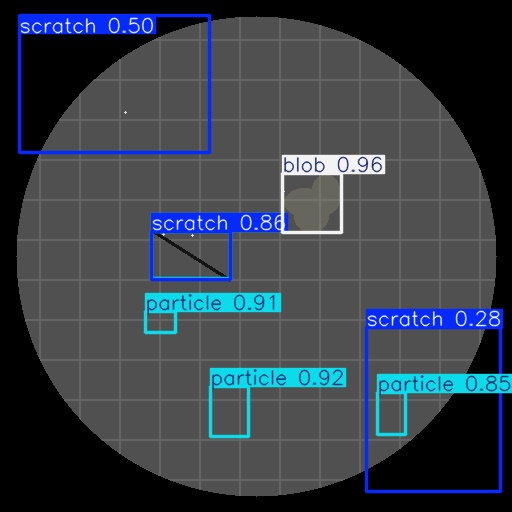


Result for: wafer_blob.jpg


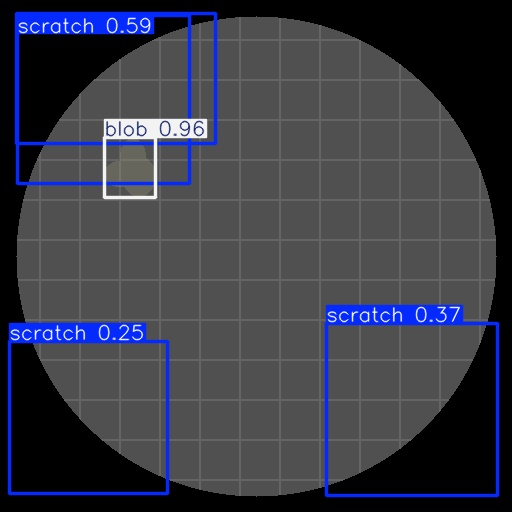


Result for: wafer_clean.jpg


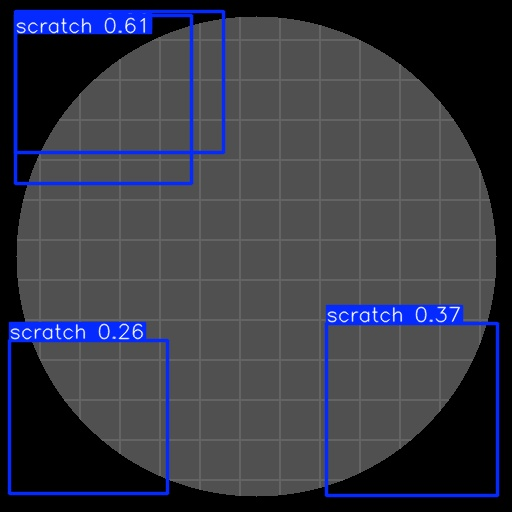


Result for: wafer_particles.jpg


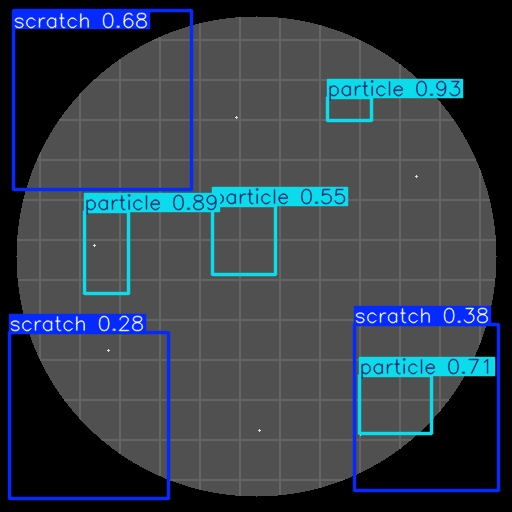


Result for: wafer_scratch.jpg


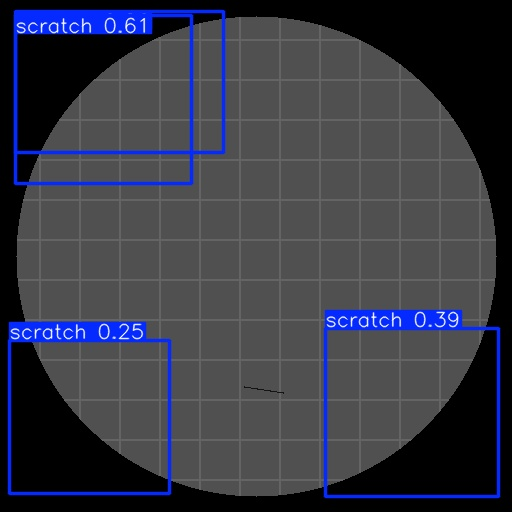

In [ ]:
import os
import glob
from IPython.display import Image, display

# --- Code to Debug and Display All Images ---

# 1. Define the correct folder path.
prediction_output_dir = 'runs/detect/predict'

# 2. Find all the .jpg image files in that folder.
result_images = sorted(glob.glob(os.path.join(prediction_output_dir, '*.jpg')))


# --- DEBUGGING STEP ---
# Let's print the number of files found and the list of filenames.
# This will confirm if the code is finding all 5 images.
print(f"✅ Found {len(result_images)} images in the folder.")
print("List of files found:", result_images)


# --- DISPLAY STEP ---
# Now, we will try to display them again.
if not result_images:
    print("\n❌ Error: No images were found.")
else:
    print("\n--- Displaying All Results ---")
    for img_path in result_images:
        print(f"\nResult for: {os.path.basename(img_path)}")
        display(Image(filename=img_path))

Generate the Final Dataset This is the complete script to generate our final, robust dataset. This version includes the clean "negative" samples and all the defect variety

In [ ]:
import os
import cv2
import numpy as np
import random
import shutil

# --- Configuration ---
DATASET_PATH = 'final_wafer_dataset'
NUM_IMAGES = 2000
IMG_WIDTH = 640
IMG_HEIGHT = 640

# --- Defect Class Mapping ---
defect_classes = {
    "scratch": 0,
    "particle": 1,
    "blob": 2,
}

# --- Helper Functions to Create Defects ---

def create_base_wafer():
    """Creates a realistic wafer background with a grid."""
    image = np.full((IMG_HEIGHT, IMG_WIDTH, 3), (50, 50, 50), dtype=np.uint8)
    for x in range(0, IMG_WIDTH, 50):
        cv2.line(image, (x, 0), (x, IMG_HEIGHT), (60, 60, 60), 1)
    for y in range(0, IMG_HEIGHT, 50):
        cv2.line(image, (0, y), (IMG_WIDTH, y), (60, 60, 60), 1)
    return image

def add_scratch(image):
    """Adds a scratch with randomized properties."""
    start_x = random.randint(20, IMG_WIDTH - 20)
    start_y = random.randint(20, IMG_HEIGHT - 20)
    end_x = start_x + random.randint(-200, 200)
    end_y = start_y + random.randint(-200, 200)
    thickness = random.randint(1, 3)
    color = (random.randint(200, 255),) * 3
    cv2.line(image, (start_x, start_y), (end_x, end_y), color, thickness)
    x_min, x_max = sorted((start_x, end_x))
    y_min, y_max = sorted((start_y, end_y))
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_max
    return image, [defect_classes["scratch"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_particle_cluster(image):
    """Adds a cluster of small particles."""
    center_x = random.randint(50, IMG_WIDTH - 50)
    center_y = random.randint(50, IMG_HEIGHT - 50)
    num_particles = random.randint(3, 10)
    all_x, all_y = [], []
    for _ in range(num_particles):
        px = center_x + random.randint(-40, 40)
        py = center_y + random.randint(-40, 40)
        radius = random.randint(1, 3)
        color = (random.randint(200, 255),) * 3
        cv2.circle(image, (px, py), radius, color, -1)
        all_x.extend([px - radius, px + radius])
        all_y.extend([py - radius, py + radius])
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min
    return image, [defect_classes["particle"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_blob(image):
    """Adds an irregular, semi-transparent blob defect."""
    overlay = image.copy()
    output = image.copy()
    center_x = random.randint(100, IMG_WIDTH - 100)
    center_y = random.randint(100, IMG_HEIGHT - 100)
    num_circles = random.randint(2, 5)
    all_x, all_y = [], []
    for _ in range(num_circles):
        radius = random.randint(20, 50)
        cx = center_x + random.randint(-30, 30)
        cy = center_y + random.randint(-30, 30)
        color = (random.randint(80, 120),) * 3
        cv2.circle(overlay, (cx, cy), radius, color, -1)
        all_x.extend([cx - radius, cx + radius])
        all_y.extend([cy - radius, cy + radius])
    transparency = random.uniform(0.3, 0.7)
    cv2.addWeighted(overlay, transparency, output, 1 - transparency, 0, image)
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min
    return image, [defect_classes["blob"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

# --- Main Generation Function ---
def generate_final_dataset():
    """Main function to generate the dataset. 20% of images will be clean."""
    images_path = os.path.join(DATASET_PATH, 'images')
    labels_path = os.path.join(DATASET_PATH, 'labels')
    if os.path.exists(DATASET_PATH):
        shutil.rmtree(DATASET_PATH)
    os.makedirs(images_path, exist_ok=True)
    os.makedirs(labels_path, exist_ok=True)
    print(f"Directories created at: {os.path.abspath(DATASET_PATH)}")

    for i in range(NUM_IMAGES):
        wafer_image = create_base_wafer()
        annotations = []

        # 20% of the time, create a clean image
        if random.random() < 0.20:
            pass
        else:
            # 80% of the time, add defects
            num_defects = random.randint(1, 4)
            for _ in range(num_defects):
                defect_type = random.choice(list(defect_classes.keys()))
                if defect_type == "scratch":
                    wafer_image, ann = add_scratch(wafer_image)
                elif defect_type == "particle":
                    wafer_image, ann = add_particle_cluster(wafer_image)
                else: # blob
                    wafer_image, ann = add_blob(wafer_image)
                if ann:
                    annotations.append(ann)

        img_name = f'wafer_{i:04d}.png'
        cv2.imwrite(os.path.join(images_path, img_name), wafer_image)

        label_name = f'wafer_{i:04d}.txt'
        with open(os.path.join(labels_path, label_name), 'w') as f:
            for ann in annotations:
                f.write(f"{ann[0]} {ann[1]} {ann[2]} {ann[3]} {ann[4]}\n")

        if (i + 1) % 200 == 0:
            print(f"  -> Generated {i + 1}/{NUM_IMAGES} images...")

    print(f"\n✅ Final dataset generation complete!")

# --- Execute the Generation ---
generate_final_dataset()

Directories created at: /content/final_wafer_dataset
  -> Generated 200/2000 images...
  -> Generated 400/2000 images...
  -> Generated 600/2000 images...
  -> Generated 800/2000 images...
  -> Generated 1000/2000 images...
  -> Generated 1200/2000 images...
  -> Generated 1400/2000 images...
  -> Generated 1600/2000 images...
  -> Generated 1800/2000 images...
  -> Generated 2000/2000 images...

✅ Final dataset generation complete!


Split Data and Create YAML File

In [ ]:
import os
import random
import shutil

# --- Configuration ---
# Defines the source of our new data and where the split data will go.
DATA_SOURCE_DIR = 'final_wafer_dataset'
OUTPUT_DIR = 'final_data_for_training'
TRAIN_RATIO = 0.7  # 70% for training
VAL_RATIO = 0.2   # 20% for validation
# The remaining 10% will be for testing.

# --- Get all image paths and shuffle them ---
images_source_path = os.path.join(DATA_SOURCE_DIR, 'images')
all_images = [f for f in os.listdir(images_source_path) if f.endswith('.png')]
random.shuffle(all_images)

# --- Calculate how many files go into each set ---
total_images = len(all_images)
train_end = int(total_images * TRAIN_RATIO)
val_end = train_end + int(total_images * VAL_RATIO)

train_files = all_images[:train_end]
val_files = all_images[train_end:val_end]
test_files = all_images[val_end:]

# --- Function to copy image and label files ---
def copy_files(file_list, set_name):
    dest_images_path = os.path.join(OUTPUT_DIR, set_name, 'images')
    dest_labels_path = os.path.join(OUTPUT_DIR, set_name, 'labels')
    os.makedirs(dest_images_path, exist_ok=True)
    os.makedirs(dest_labels_path, exist_ok=True)

    source_images_path = os.path.join(DATA_SOURCE_DIR, 'images')
    source_labels_path = os.path.join(DATA_SOURCE_DIR, 'labels')

    for filename in file_list:
        base_name = os.path.splitext(filename)[0]
        # Copy the image file
        shutil.copy(os.path.join(source_images_path, filename), os.path.join(dest_images_path, filename))
        # Copy the corresponding label file
        shutil.copy(os.path.join(source_labels_path, f'{base_name}.txt'), os.path.join(dest_labels_path, f'{base_name}.txt'))

    print(f"  -> Copied {len(file_list)} files to the '{set_name}' set.")

# --- Clean up old directories and run the split ---
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

# --- Create the data.yaml file ---
# This file tells YOLO all about our dataset.
yaml_content = f"""
path: {os.path.abspath(OUTPUT_DIR)}
train: train/images
val: val/images
test: test/images

nc: 3
names: ['scratch', 'particle', 'blob']
"""
with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print(f"\n✅ Dataset successfully split.")
print(f"✅ 'data.yaml' created at '{os.path.join(OUTPUT_DIR, 'data.yaml')}'")

  -> Copied 1400 files to the 'train' set.
  -> Copied 400 files to the 'val' set.
  -> Copied 200 files to the 'test' set.

✅ Dataset successfully split.
✅ 'data.yaml' created at 'final_data_for_training/data.yaml'


Re-install the Libraries

In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

 Train the Final Robust Model

In [ ]:
from ultralytics import YOLO

# --- Final Model Training ---
# This function loads the pre-trained YOLOv8 model and fine-tunes it
# on our final dataset with heavy data augmentation enabled.

# 1. Load the pre-trained model.
model = YOLO('yolov8n.pt')

# 2. Start the training process.
print("🚀 Starting final model training with data augmentation...")
results = model.train(
    data='final_data_for_training/data.yaml',
    epochs=50,
    imgsz=640,

    # --- NEW: Augmentation Strategy ---
    # These parameters create more training variety, which helps the model
    # generalize better and reduces both false positives and false negatives.
    degrees=15,      # Randomly rotate images by up to 15 degrees.
    translate=0.1,   # Randomly shift images horizontally and vertically by 10%.
    scale=0.1,       # Randomly zoom in or out by 10%.
    fliplr=0.5,      # 50% chance of flipping images horizontally.
    # ---

    project='wafer_final_runs',
    name='final_robust_model_v1'
)

print("✅ Final training complete!")
print(f"All results, charts, and model weights are saved in: {results.save_dir}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 210MB/s]

🚀 Starting final model training with data augmentation...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=final_data_for_training/data.yaml, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=final_robust_model_v1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=wafer_final_runs, rect=False, res

100%|██████████| 755k/755k [00:00<00:00, 97.5MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 417MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 18.4±4.8 MB/s, size: 25.8 KB)


train: Scanning /content/final_data_for_training/train/labels... 1400 images, 272 backgrounds, 94 corrupt: 100%|██████████| 1400/1400 [00:01<00:00, 1010.65it/s]

train: /content/final_data_for_training/train/images/wafer_0030.png: ignoring corrupt image/label: negative class labels [   -0.03125]
train: /content/final_data_for_training/train/images/wafer_0054.png: ignoring corrupt image/label: negative class labels [  -0.042188]
train: /content/final_data_for_training/train/images/wafer_0069.png: ignoring corrupt image/label: negative class labels [  -0.029687]
train: /content/final_data_for_training/train/images/wafer_0080.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1125]
train: /content/final_data_for_training/train/images/wafer_0081.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0383]
train: /content/final_data_for_training/train/images/wafer_0110.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0328]
train: /content/final_data_for_training/train/images/wafer_0132.png: ignoring corrupt image/label: non-normalized or out of 

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 14.7±6.3 MB/s, size: 26.6 KB)


val: Scanning /content/final_data_for_training/val/labels... 400 images, 79 backgrounds, 21 corrupt: 100%|██████████| 400/400 [00:00<00:00, 867.98it/s]

val: /content/final_data_for_training/val/images/wafer_0092.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0547]
val: /content/final_data_for_training/val/images/wafer_0274.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0422]
val: /content/final_data_for_training/val/images/wafer_0304.png: ignoring corrupt image/label: negative class labels [    -0.0125]
val: /content/final_data_for_training/val/images/wafer_0400.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0609]
val: /content/final_data_for_training/val/images/wafer_0453.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0773]
val: /content/final_data_for_training/val/images/wafer_0617.png: ignoring corrupt image/label: negative class labels [  -0.083594]
val: /content/final_data_for_training/val/images/wafer_0633.png: ignoring corrupt image/label: non-normalized or out of bounds

Plotting labels to wafer_final_runs/final_robust_model_v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to wafer_final_runs/final_robust_model_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.03G      1.281      2.491      1.188         18        640: 100%|██████████| 82/82 [00:25<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]

                   all        379        726      0.991      0.379      0.638      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.52G       1.04      1.461      1.063         14        640: 100%|██████████| 82/82 [00:23<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.14it/s]

                   all        379        726      0.929      0.608      0.639      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.53G      1.076      1.202      1.117         10        640: 100%|██████████| 82/82 [00:23<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]

                   all        379        726      0.952      0.617      0.647      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.55G      1.032     0.9418      1.096         13        640: 100%|██████████| 82/82 [00:23<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]

                   all        379        726      0.975      0.631      0.652       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.57G     0.9717     0.8023       1.07         20        640: 100%|██████████| 82/82 [00:23<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        379        726      0.964      0.643      0.653      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.59G     0.9365     0.7144      1.044         14        640: 100%|██████████| 82/82 [00:23<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.75it/s]

                   all        379        726      0.965      0.634       0.65      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.6G     0.8949     0.6412      1.045         19        640: 100%|██████████| 82/82 [00:22<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]


                   all        379        726      0.638      0.644      0.657      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.62G     0.8943     0.6327      1.051         27        640: 100%|██████████| 82/82 [00:23<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        379        726      0.631      0.639      0.652      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.64G     0.8593     0.5954      1.028         14        640: 100%|██████████| 82/82 [00:23<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.51it/s]


                   all        379        726      0.653      0.645      0.658       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.65G     0.8441     0.5695      1.032         13        640: 100%|██████████| 82/82 [00:23<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        379        726      0.647      0.652      0.661      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.67G     0.7923     0.5478      1.003         12        640: 100%|██████████| 82/82 [00:23<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

                   all        379        726      0.643       0.64      0.657      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.69G     0.7565     0.5249     0.9922         12        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.64it/s]

                   all        379        726      0.652      0.652      0.659      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.71G     0.7358     0.5008     0.9896         25        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.16it/s]

                   all        379        726      0.651      0.654      0.658      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.72G     0.7142     0.4816     0.9866         18        640: 100%|██████████| 82/82 [00:22<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]

                   all        379        726      0.645      0.656       0.66      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.74G     0.6906     0.4692     0.9752         14        640: 100%|██████████| 82/82 [00:22<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.84it/s]

                   all        379        726      0.652      0.647      0.659      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.76G     0.6721     0.4748     0.9715         21        640: 100%|██████████| 82/82 [00:23<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

                   all        379        726      0.638      0.659      0.659      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.77G     0.6449     0.4552     0.9563         15        640: 100%|██████████| 82/82 [00:23<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        379        726       0.64      0.652      0.659      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.79G     0.6435     0.4442     0.9695         14        640: 100%|██████████| 82/82 [00:23<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        379        726      0.648      0.655      0.661      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.81G     0.6584      0.454     0.9676         14        640: 100%|██████████| 82/82 [00:23<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        379        726      0.636      0.656      0.658      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.82G     0.6323     0.4402     0.9519         17        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

                   all        379        726      0.632      0.658       0.66      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.84G     0.6263     0.4389     0.9532         17        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.17it/s]

                   all        379        726      0.658      0.646       0.66      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.86G     0.5724     0.4092     0.9321         13        640: 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

                   all        379        726      0.646      0.652       0.66       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.88G     0.6119      0.427      0.955         20        640: 100%|██████████| 82/82 [00:22<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.79it/s]

                   all        379        726      0.648      0.653       0.66      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.89G     0.5441     0.3781     0.9233         21        640: 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.33it/s]

                   all        379        726      0.651      0.649       0.66        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.91G     0.5472     0.3881     0.9299         11        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

                   all        379        726      0.653      0.653      0.661      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.93G     0.5428     0.3935      0.931         25        640: 100%|██████████| 82/82 [00:23<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

                   all        379        726      0.658      0.652       0.66      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.94G     0.5228     0.3693      0.919         17        640: 100%|██████████| 82/82 [00:23<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        379        726      0.653      0.654      0.662      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.96G     0.5475     0.3825     0.9297         22        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        379        726      0.652      0.651      0.661      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.98G     0.5366     0.3843     0.9328         18        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

                   all        379        726      0.653      0.651      0.662      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         3G      0.524     0.3729     0.9225         11        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.03it/s]

                   all        379        726      0.654      0.653      0.661      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.01G     0.4994     0.3702     0.9181         12        640: 100%|██████████| 82/82 [00:22<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]


                   all        379        726      0.655      0.655      0.661      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.03G     0.5165     0.3723     0.9337         14        640: 100%|██████████| 82/82 [00:22<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]

                   all        379        726      0.662      0.653      0.663      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.05G     0.4949     0.3538     0.9081         12        640: 100%|██████████| 82/82 [00:23<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

                   all        379        726      0.652      0.657      0.661      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.06G     0.5162     0.3623     0.9239         20        640: 100%|██████████| 82/82 [00:23<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        379        726      0.655      0.655      0.662      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.08G     0.4987     0.3486     0.9252         15        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.45it/s]


                   all        379        726      0.655      0.658      0.662      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.1G     0.4951      0.355     0.9093         20        640: 100%|██████████| 82/82 [00:23<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.79it/s]

                   all        379        726      0.656      0.659      0.662       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.12G     0.4709     0.3354     0.9049          9        640: 100%|██████████| 82/82 [00:23<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.55it/s]

                   all        379        726      0.645      0.654      0.662      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.13G     0.4567     0.3239     0.9079         15        640: 100%|██████████| 82/82 [00:23<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.54it/s]

                   all        379        726      0.651      0.658      0.662      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.15G     0.4655     0.3316     0.9062         17        640: 100%|██████████| 82/82 [00:22<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]

                   all        379        726      0.656      0.656      0.662      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.17G     0.4713     0.3343     0.9059         18        640: 100%|██████████| 82/82 [00:21<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.82it/s]

                   all        379        726      0.656      0.658      0.661      0.639


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.18G      0.497     0.4776     0.9166         18        640: 100%|██████████| 82/82 [00:22<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.97it/s]

                   all        379        726       0.99      0.655      0.662      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       3.2G     0.4567     0.4031     0.8953         25        640: 100%|██████████| 82/82 [00:22<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.44it/s]

                   all        379        726       0.99      0.658      0.662       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.22G     0.4564     0.4009     0.8861         22        640: 100%|██████████| 82/82 [00:21<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]


                   all        379        726      0.989      0.658      0.662      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.23G     0.4481     0.3877     0.8871         13        640: 100%|██████████| 82/82 [00:22<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        379        726      0.986      0.659      0.662      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.25G     0.4381      0.375     0.8812         18        640: 100%|██████████| 82/82 [00:22<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        379        726       0.99      0.659      0.662      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.27G     0.4391     0.3715     0.8822          9        640: 100%|██████████| 82/82 [00:22<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]

                   all        379        726      0.987       0.66      0.663      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.29G     0.4323     0.3703     0.8746         17        640: 100%|██████████| 82/82 [00:22<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

                   all        379        726      0.988      0.658      0.663      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       3.3G     0.4213     0.3556     0.8706         27        640: 100%|██████████| 82/82 [00:21<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.31it/s]

                   all        379        726      0.989       0.66      0.663      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.32G     0.4032     0.3497     0.8625         24        640: 100%|██████████| 82/82 [00:22<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

                   all        379        726      0.989      0.657      0.662      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.34G     0.4051     0.3456     0.8646         16        640: 100%|██████████| 82/82 [00:22<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        379        726      0.989      0.659      0.662      0.646



50 epochs completed in 0.377 hours.
Optimizer stripped from wafer_final_runs/final_robust_model_v1/weights/last.pt, 6.2MB
Optimizer stripped from wafer_final_runs/final_robust_model_v1/weights/best.pt, 6.2MB

Validating wafer_final_runs/final_robust_model_v1/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


                   all        379        726      0.989      0.659      0.662      0.647
               scratch        171        231          1          0          0          0
              particle        180        259      0.973       0.98      0.992      0.949
                  blob        174        236      0.994      0.996      0.995       0.99
Speed: 0.4ms preprocess, 2.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to wafer_final_runs/final_robust_model_v1
✅ Final training complete!
All results, charts, and model weights are saved in: wafer_final_runs/final_robust_model_v1


The Problem: The Model Didn't Learn "Scratch"
Look at the final validation scores for each class:

     
The model learned to detect particles and blobs almost perfectly (scores of 0.949 and 0.99). This is fantastic!

However, for the scratch class, the scores are all zero. This means the model has completely failed to learn what a scratch looks like.

The Root Cause: A Typo in the Data
The reason is a single-line typo in the data generation script I gave you. In the add_scratch function, the code to calculate the bounding box height was accidentally written as:
height = y_max - y_max

This means every scratch in our 2000-image dataset was created with a height of zero. The YOLO trainer was smart enough to see this "corrupt" data and ignore it completely. As a result, the model never saw a single valid example of a scratch and never learned to detect them.

Re-Generate Data with Corrected Code

In [ ]:
import os
import cv2
import numpy as np
import random
import shutil

# --- Configuration ---
DATASET_PATH = 'final_wafer_dataset_v2' # New name to avoid confusion
NUM_IMAGES = 2000
IMG_WIDTH = 640
IMG_HEIGHT = 640
defect_classes = {"scratch": 0, "particle": 1, "blob": 2}

# --- Helper Functions ---
def create_base_wafer():
    image = np.full((IMG_HEIGHT, IMG_WIDTH, 3), (50, 50, 50), dtype=np.uint8)
    for x in range(0, IMG_WIDTH, 50): cv2.line(image, (x, 0), (x, IMG_HEIGHT), (60, 60, 60), 1)
    for y in range(0, IMG_HEIGHT, 50): cv2.line(image, (0, y), (IMG_WIDTH, y), (60, 60, 60), 1)
    return image

def add_scratch(image):
    start_x, start_y = random.randint(20, IMG_WIDTH - 20), random.randint(20, IMG_HEIGHT - 20)
    end_x, end_y = start_x + random.randint(-200, 200), start_y + random.randint(-200, 200)
    thickness, color = random.randint(1, 3), (random.randint(200, 255),) * 3
    cv2.line(image, (start_x, start_y), (end_x, end_y), color, thickness)
    x_min, x_max = sorted((start_x, end_x))
    y_min, y_max = sorted((start_y, end_y))
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width = x_max - x_min

    # --- BUG FIX ---
    height = y_max - y_min # Corrected from y_max - y_max
    # ---

    return image, [defect_classes["scratch"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_particle_cluster(image):
    center_x, center_y = random.randint(50, IMG_WIDTH - 50), random.randint(50, IMG_HEIGHT - 50)
    num_particles, all_x, all_y = random.randint(3, 10), [], []
    for _ in range(num_particles):
        px, py = center_x + random.randint(-40, 40), center_y + random.randint(-40, 40)
        radius, color = random.randint(1, 3), (random.randint(200, 255),) * 3
        cv2.circle(image, (px, py), radius, color, -1)
        all_x.extend([px - radius, px + radius]); all_y.extend([py - radius, py + radius])
    x_min, x_max, y_min, y_max = min(all_x), max(all_x), min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    return image, [defect_classes["particle"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_blob(image):
    overlay, output = image.copy(), image.copy()
    center_x, center_y = random.randint(100, IMG_WIDTH - 100), random.randint(100, IMG_HEIGHT - 100)
    num_circles, all_x, all_y = random.randint(2, 5), [], []
    for _ in range(num_circles):
        radius, cx, cy = random.randint(20, 50), center_x + random.randint(-30, 30), center_y + random.randint(-30, 30)
        color = (random.randint(80, 120),) * 3
        cv2.circle(overlay, (cx, cy), radius, color, -1)
        all_x.extend([cx - radius, cx + radius]); all_y.extend([cy - radius, cy + radius])
    transparency = random.uniform(0.3, 0.7)
    cv2.addWeighted(overlay, transparency, output, 1 - transparency, 0, image)
    x_min, x_max, y_min, y_max = min(all_x), max(all_x), min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    return image, [defect_classes["blob"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

# --- Main Generation Function ---
def generate_corrected_dataset():
    images_path = os.path.join(DATASET_PATH, 'images')
    labels_path = os.path.join(DATASET_PATH, 'labels')
    if os.path.exists(DATASET_PATH): shutil.rmtree(DATASET_PATH)
    os.makedirs(images_path, exist_ok=True); os.makedirs(labels_path, exist_ok=True)
    print(f"Directories created at: {os.path.abspath(DATASET_PATH)}")
    for i in range(NUM_IMAGES):
        wafer_image, annotations = create_base_wafer(), []
        if random.random() >= 0.20:
            for _ in range(random.randint(1, 4)):
                defect_type = random.choice(list(defect_classes.keys()))
                if defect_type == "scratch": wafer_image, ann = add_scratch(wafer_image)
                elif defect_type == "particle": wafer_image, ann = add_particle_cluster(wafer_image)
                else: wafer_image, ann = add_blob(wafer_image)
                if ann and ann[3] > 0 and ann[4] > 0: annotations.append(ann)
        img_name, label_name = f'wafer_{i:04d}.png', f'wafer_{i:04d}.txt'
        cv2.imwrite(os.path.join(images_path, img_name), wafer_image)
        with open(os.path.join(labels_path, label_name), 'w') as f:
            for ann in annotations: f.write(f"{ann[0]} {ann[1]} {ann[2]} {ann[3]} {ann[4]}\n")
        if (i + 1) % 200 == 0: print(f"  -> Generated {i + 1}/{NUM_IMAGES} images...")
    print(f"\n✅ Corrected dataset generation complete!")

generate_corrected_dataset()

Directories created at: /content/final_wafer_dataset_v2
  -> Generated 200/2000 images...
  -> Generated 400/2000 images...
  -> Generated 600/2000 images...
  -> Generated 800/2000 images...
  -> Generated 1000/2000 images...
  -> Generated 1200/2000 images...
  -> Generated 1400/2000 images...
  -> Generated 1600/2000 images...
  -> Generated 1800/2000 images...
  -> Generated 2000/2000 images...

✅ Corrected dataset generation complete!


Split the Corrected Data

In [ ]:
import os
import random
import shutil

# --- Configuration ---
# We are using the new, corrected dataset as the source.
DATA_SOURCE_DIR = 'final_wafer_dataset_v2'
OUTPUT_DIR = 'final_data_for_training_v2'
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
# The remaining 10% will be for the test set.

# --- Get all image paths and shuffle them for random distribution ---
images_source_path = os.path.join(DATA_SOURCE_DIR, 'images')
all_images = [f for f in os.listdir(images_source_path) if f.endswith('.png')]
random.shuffle(all_images)

# --- Calculate how many files go into each set ---
total_images = len(all_images)
train_end = int(total_images * TRAIN_RATIO)
val_end = train_end + int(total_images * VAL_RATIO)

train_files = all_images[:train_end]
val_files = all_images[train_end:val_end]
test_files = all_images[val_end:]

# --- Function to copy image and label files ---
def copy_files(file_list, set_name):
    dest_images_path = os.path.join(OUTPUT_DIR, set_name, 'images')
    dest_labels_path = os.path.join(OUTPUT_DIR, set_name, 'labels')
    os.makedirs(dest_images_path, exist_ok=True)
    os.makedirs(dest_labels_path, exist_ok=True)

    source_images_path = os.path.join(DATA_SOURCE_DIR, 'images')
    source_labels_path = os.path.join(DATA_SOURCE_DIR, 'labels')

    for filename in file_list:
        base_name = os.path.splitext(filename)[0]
        shutil.copy(os.path.join(source_images_path, filename), os.path.join(dest_images_path, filename))
        shutil.copy(os.path.join(source_labels_path, f'{base_name}.txt'), os.path.join(dest_labels_path, f'{base_name}.txt'))

    print(f"  -> Copied {len(file_list)} files to the '{set_name}' set.")

# --- Clean up old directories and run the split ---
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

# --- Create the final data.yaml file ---
yaml_content = f"""
path: {os.path.abspath(OUTPUT_DIR)}
train: train/images
val: val/images
test: test/images

nc: 3
names: ['scratch', 'particle', 'blob']
"""
with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print(f"\n✅ Corrected dataset successfully split.")
print(f"✅ 'data.yaml' created at '{os.path.join(OUTPUT_DIR, 'data.yaml')}'")

  -> Copied 1400 files to the 'train' set.
  -> Copied 400 files to the 'val' set.
  -> Copied 200 files to the 'test' set.

✅ Corrected dataset successfully split.
✅ 'data.yaml' created at 'final_data_for_training_v2/data.yaml'


Train the Final Corrected Model


In [ ]:
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model.
model = YOLO('yolov8n.pt')

# Start the training process on the corrected dataset with augmentations.
print("🚀 Starting the final, corrected model training...")
results = model.train(
    data='final_data_for_training_v2/data.yaml', # Using the new, corrected data
    epochs=50,
    imgsz=640,
    degrees=15,      # Random rotation
    translate=0.1,   # Random translation
    scale=0.1,       # Random zoom
    fliplr=0.5,      # Horizontal flip
    project='wafer_final_runs',
    name='final_model_v2_correct_data' # A new name for this final run
)

print("✅ Final training complete!")
print(f"All results are saved in: {results.save_dir}")

🚀 Starting the final, corrected model training...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=final_data_for_training_v2/data.yaml, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=final_model_v2_correct_data, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

train: Scanning /content/final_data_for_training_v2/train/labels... 1400 images, 320 backgrounds, 93 corrupt: 100%|██████████| 1400/1400 [00:00<00:00, 2246.30it/s]

train: /content/final_data_for_training_v2/train/images/wafer_0010.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0312]
train: /content/final_data_for_training_v2/train/images/wafer_0027.png: ignoring corrupt image/label: negative class labels [  -0.032031]
train: /content/final_data_for_training_v2/train/images/wafer_0030.png: ignoring corrupt image/label: negative class labels [  -0.090625]
train: /content/final_data_for_training_v2/train/images/wafer_0057.png: ignoring corrupt image/label: negative class labels [  -0.064062]
train: /content/final_data_for_training_v2/train/images/wafer_0121.png: ignoring corrupt image/label: negative class labels [  -0.024219]
train: /content/final_data_for_training_v2/train/images/wafer_0140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0672]
train: /content/final_data_for_training_v2/train/images/wafer_0186.png: ignoring corrupt image/label: negative class labels [  -

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 438.7±293.2 MB/s, size: 25.4 KB)


val: Scanning /content/final_data_for_training_v2/val/labels... 400 images, 65 backgrounds, 16 corrupt: 100%|██████████| 400/400 [00:00<00:00, 860.48it/s]

val: /content/final_data_for_training_v2/val/images/wafer_0089.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0398]
val: /content/final_data_for_training_v2/val/images/wafer_0232.png: ignoring corrupt image/label: negative class labels [  -0.023438]
val: /content/final_data_for_training_v2/val/images/wafer_0287.png: ignoring corrupt image/label: negative class labels [  -0.057031]
val: /content/final_data_for_training_v2/val/images/wafer_0343.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0906]
val: /content/final_data_for_training_v2/val/images/wafer_0390.png: ignoring corrupt image/label: negative class labels [   -0.05625]
val: /content/final_data_for_training_v2/val/images/wafer_0398.png: ignoring corrupt image/label: negative class labels [  -0.038281]
val: /content/final_data_for_training_v2/val/images/wafer_0659.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.04

Plotting labels to wafer_final_runs/final_model_v2_correct_data/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to wafer_final_runs/final_model_v2_correct_data
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.17G      1.457      2.433      1.268         11        640: 100%|██████████| 82/82 [00:25<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.48it/s]

                   all        384        777      0.717      0.357      0.673      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.63G      1.298       1.63      1.235         25        640: 100%|██████████| 82/82 [00:24<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.31it/s]

                   all        384        777      0.814      0.796      0.825      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.63G      1.241      1.332      1.242         17        640: 100%|██████████| 82/82 [00:23<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.22it/s]

                   all        384        777      0.837      0.805      0.824        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.63G      1.205      1.167      1.232         37        640: 100%|██████████| 82/82 [00:23<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

                   all        384        777      0.878      0.818      0.862      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.63G      1.154      1.015      1.212         19        640: 100%|██████████| 82/82 [00:23<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        384        777      0.875      0.828      0.868      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.63G      1.144     0.9356      1.196         32        640: 100%|██████████| 82/82 [00:22<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

                   all        384        777      0.921      0.858      0.899      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.63G      1.144     0.9135      1.196         22        640: 100%|██████████| 82/82 [00:22<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]

                   all        384        777      0.874      0.797      0.848      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.64G      1.081     0.8362      1.181         27        640: 100%|██████████| 82/82 [00:22<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.12it/s]

                   all        384        777      0.878      0.874      0.906      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.65G      1.034     0.8082      1.155         20        640: 100%|██████████| 82/82 [00:23<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        384        777      0.909       0.85      0.906      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.67G     0.9836     0.7639      1.134         21        640: 100%|██████████| 82/82 [00:23<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.52it/s]

                   all        384        777      0.905      0.868       0.91      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.69G     0.9409     0.7185      1.119         30        640: 100%|██████████| 82/82 [00:23<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

                   all        384        777       0.92      0.874      0.918      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.71G     0.8964     0.6878      1.104         26        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.47it/s]

                   all        384        777      0.933      0.874      0.922      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.72G     0.8864     0.6718      1.083         29        640: 100%|██████████| 82/82 [00:23<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        384        777      0.903      0.881      0.921       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.74G     0.8534     0.6444      1.077         26        640: 100%|██████████| 82/82 [00:23<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        384        777      0.917      0.895       0.93      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.76G     0.8275     0.6415      1.073         19        640: 100%|██████████| 82/82 [00:23<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.58it/s]

                   all        384        777      0.943      0.883      0.933      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.77G     0.8176     0.6244       1.06         27        640: 100%|██████████| 82/82 [00:23<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.23it/s]

                   all        384        777      0.937      0.894       0.93      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.79G     0.8111     0.6176      1.067         17        640: 100%|██████████| 82/82 [00:22<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.85it/s]

                   all        384        777      0.933      0.883      0.935      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.81G     0.7942     0.6231      1.061         31        640: 100%|██████████| 82/82 [00:22<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.72it/s]

                   all        384        777      0.927      0.907      0.939      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.82G     0.7627     0.6042      1.042         20        640: 100%|██████████| 82/82 [00:22<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.78it/s]

                   all        384        777      0.917      0.911      0.937      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.84G     0.7395     0.5856      1.034         34        640: 100%|██████████| 82/82 [00:22<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.94it/s]

                   all        384        777       0.91      0.923      0.942      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.86G     0.7535     0.5845      1.038         24        640: 100%|██████████| 82/82 [00:23<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.69it/s]

                   all        384        777      0.937      0.883      0.939       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.88G     0.7195     0.5738      1.022         27        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]

                   all        384        777      0.937      0.894      0.941      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.89G      0.719     0.5711      1.028         21        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        384        777      0.946      0.897      0.935      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.91G     0.7073     0.5601      1.018         17        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        384        777      0.943      0.905      0.937      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.93G     0.7114     0.5564      1.028         24        640: 100%|██████████| 82/82 [00:23<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.60it/s]

                   all        384        777      0.909      0.924       0.94      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.95G     0.6998     0.5438      1.026         22        640: 100%|██████████| 82/82 [00:23<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]

                   all        384        777      0.945      0.892      0.937      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.96G     0.6864     0.5416      1.012         35        640: 100%|██████████| 82/82 [00:23<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.66it/s]

                   all        384        777      0.925      0.923       0.95      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.98G     0.6754      0.533      1.012         20        640: 100%|██████████| 82/82 [00:23<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.14it/s]

                   all        384        777      0.943      0.914      0.947      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         3G     0.6615     0.5244     0.9993         32        640: 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.01it/s]

                   all        384        777      0.935      0.905      0.946       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.01G     0.6404     0.5192      1.001         20        640: 100%|██████████| 82/82 [00:22<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.71it/s]

                   all        384        777      0.949      0.906      0.948      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.03G      0.642     0.5204     0.9981         29        640: 100%|██████████| 82/82 [00:22<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.76it/s]

                   all        384        777       0.96      0.913      0.947      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.05G     0.6485     0.5001     0.9987         25        640: 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.34it/s]

                   all        384        777       0.94      0.898      0.943      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.06G     0.6236     0.5002     0.9895         25        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

                   all        384        777      0.934      0.911       0.95      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.08G      0.617     0.4926     0.9856         28        640: 100%|██████████| 82/82 [00:23<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

                   all        384        777      0.935      0.916      0.949      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       3.1G     0.5984     0.5014     0.9754         31        640: 100%|██████████| 82/82 [00:23<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

                   all        384        777      0.932      0.914      0.952      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.12G     0.6014     0.4649     0.9852         25        640: 100%|██████████| 82/82 [00:23<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

                   all        384        777       0.95      0.903      0.953      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.13G     0.5987     0.4849     0.9827         31        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        384        777      0.921      0.938      0.952      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.15G     0.6046     0.4827     0.9854         26        640: 100%|██████████| 82/82 [00:23<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

                   all        384        777      0.937      0.924      0.953      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.17G     0.5742      0.477     0.9569         27        640: 100%|██████████| 82/82 [00:23<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]

                   all        384        777      0.942      0.921      0.952      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.18G     0.5847     0.4713     0.9698         30        640: 100%|██████████| 82/82 [00:23<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.63it/s]

                   all        384        777      0.944       0.92      0.954      0.839


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       3.2G     0.4209     0.3248     0.8627         26        640: 100%|██████████| 82/82 [00:23<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.90it/s]

                   all        384        777      0.949      0.911      0.952      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.22G     0.4014     0.3081     0.8571         26        640: 100%|██████████| 82/82 [00:21<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.98it/s]

                   all        384        777      0.961      0.926      0.957      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.23G     0.4076     0.3071     0.8582         21        640: 100%|██████████| 82/82 [00:21<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.99it/s]

                   all        384        777      0.948      0.931      0.959      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.25G     0.3879     0.3018     0.8511         20        640: 100%|██████████| 82/82 [00:20<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.94it/s]

                   all        384        777      0.947      0.937      0.961      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.27G     0.3787     0.2952      0.849         20        640: 100%|██████████| 82/82 [00:21<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.96it/s]

                   all        384        777      0.958      0.936      0.961      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.29G     0.3785     0.2947      0.853         23        640: 100%|██████████| 82/82 [00:21<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]

                   all        384        777      0.953      0.926      0.959      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       3.3G     0.3674     0.2854     0.8418         19        640: 100%|██████████| 82/82 [00:21<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.15it/s]

                   all        384        777      0.958      0.925      0.962      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.32G     0.3673     0.2836     0.8534         15        640: 100%|██████████| 82/82 [00:21<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.40it/s]

                   all        384        777      0.965      0.926      0.962      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.34G     0.3594     0.2845     0.8474         27        640: 100%|██████████| 82/82 [00:21<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

                   all        384        777      0.958      0.926      0.961      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.36G     0.3505     0.2734     0.8478         27        640: 100%|██████████| 82/82 [00:21<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]


                   all        384        777      0.962      0.926      0.961      0.869

50 epochs completed in 0.374 hours.
Optimizer stripped from wafer_final_runs/final_model_v2_correct_data/weights/last.pt, 6.2MB
Optimizer stripped from wafer_final_runs/final_model_v2_correct_data/weights/best.pt, 6.2MB

Validating wafer_final_runs/final_model_v2_correct_data/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


                   all        384        777      0.958      0.926      0.961      0.871
               scratch        171        220      0.919      0.825      0.911       0.72
              particle        207        292      0.976      0.961      0.978      0.913
                  blob        191        265      0.978      0.992      0.995      0.981
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to wafer_final_runs/final_model_v2_correct_data
✅ Final training complete!
All results are saved in: wafer_final_runs/final_model_v2_correct_data


It will list every file and folder currently in your Colab session.

In [ ]:
# This command lists all files in the current directory.
!ls

final_data_for_training     final_wafer_dataset_v2  yolo11n.pt
final_data_for_training_v2  sample_data		    yolov8n.pt
final_wafer_dataset	    wafer_final_runs


Unzip the Test Images

In [ ]:
!unzip -o /test_images.zip -d test_images_unzipped

Archive:  /test_images.zip
   creating: test_images_unzipped/test_images/
  inflating: test_images_unzipped/test_images/wafer_blob.png  
  inflating: test_images_unzipped/test_images/wafer_scratch.png  
  inflating: test_images_unzipped/test_images/wafer_all_defects.png  
  inflating: test_images_unzipped/test_images/wafer_particles.png  
  inflating: test_images_unzipped/test_images/wafer_clean.png  


Run the Final Evaluation

Loading final model from: wafer_final_runs/final_model_v2_correct_data/weights/best.pt
✅ Final model loaded successfully.

🚀 Running final predictions with conf=0.5...

image 1/5 /content/test_images_unzipped/test_images/wafer_all_defects.png: 640x640 2 scratchs, 3 particles, 1 blob, 9.7ms
image 2/5 /content/test_images_unzipped/test_images/wafer_blob.png: 640x640 1 scratch, 1 blob, 7.4ms
image 3/5 /content/test_images_unzipped/test_images/wafer_clean.png: 640x640 1 scratch, 8.4ms
image 4/5 /content/test_images_unzipped/test_images/wafer_particles.png: 640x640 1 scratch, 2 particles, 7.4ms
image 5/5 /content/test_images_unzipped/test_images/wafer_scratch.png: 640x640 1 scratch, 7.3ms
Speed: 3.3ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
✅ Final predictions complete!

--- ✅ Final, Corrected Prediction Results ---

Final result for: wafer_all_defects.jpg


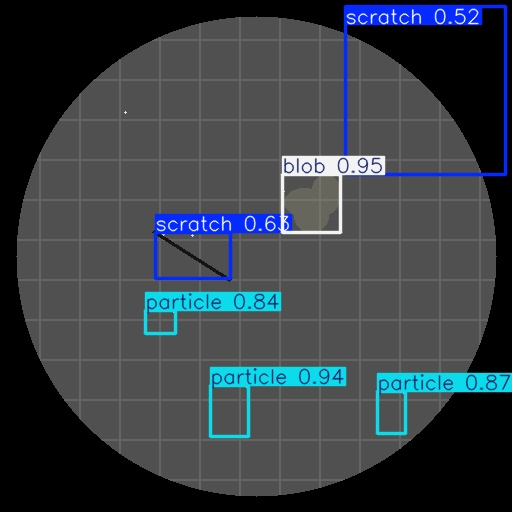


Final result for: wafer_blob.jpg


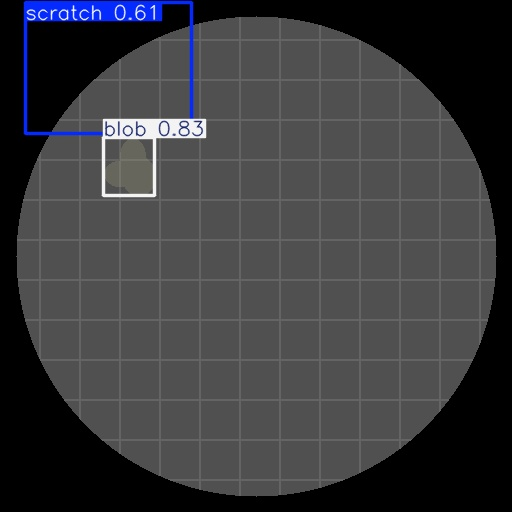


Final result for: wafer_clean.jpg


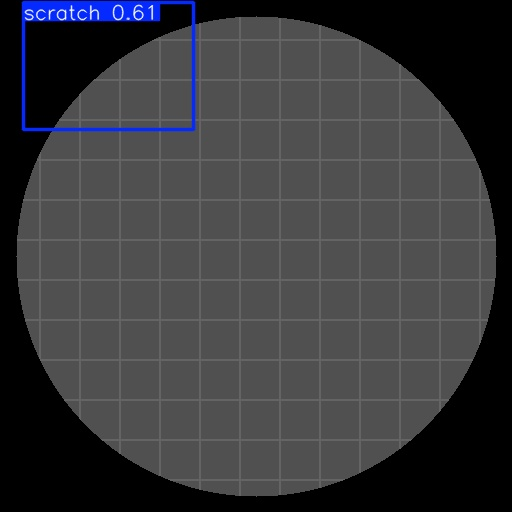


Final result for: wafer_particles.jpg


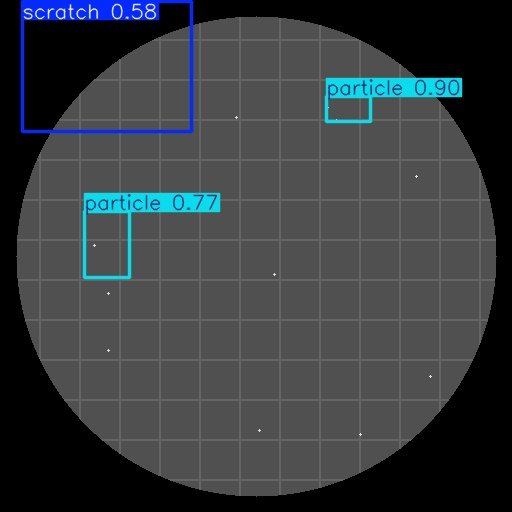


Final result for: wafer_scratch.jpg


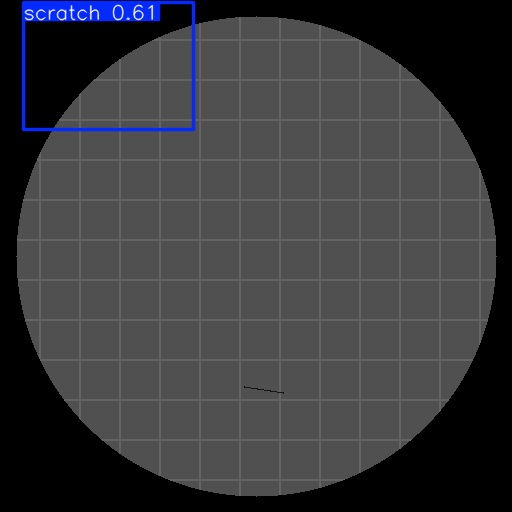

In [ ]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- Final Model Evaluation ---
def final_evaluation():
    """
    Loads our final, corrected model and runs it on the challenging test
    images to verify its superior performance.
    """
    # 1. Define the path to our best and final trained model.
    model_path = 'wafer_final_runs/final_model_v2_correct_data/weights/best.pt'

    # 2. Define the folder with the test images.
    test_images_folder = 'test_images_unzipped/test_images'

    # Safety checks
    if not os.path.exists(model_path):
        print(f"❌ ERROR: Final model not found at {model_path}")
        return
    if not os.path.exists(test_images_folder):
        print(f"❌ ERROR: Test images folder not found. Please ensure 'test_images.zip' is uploaded and unzipped.")
        return

    # 3. Load our final, powerful model.
    print(f"Loading final model from: {model_path}")
    model = YOLO(model_path)
    print("✅ Final model loaded successfully.")

    # 4. Run prediction with the confidence threshold.
    print("\n🚀 Running final predictions with conf=0.5...")
    results = model.predict(
        source=test_images_folder,
        save=True,
        conf=0.5 # Only show detections the model is at least 50% sure about.
    )
    print("✅ Final predictions complete!")

    # 5. Display the results.
    prediction_output_dir = results[0].save_dir
    result_images = sorted(glob.glob(os.path.join(prediction_output_dir, '*.jpg')))

    if not result_images:
        print("\nCould not find any result images. Please check the latest 'predict' folder inside the 'runs/detect/' directory.")
    else:
        print("\n--- ✅ Final, Corrected Prediction Results ---")
        for img_path in result_images:
            print(f"\nFinal result for: {os.path.basename(img_path)}")
            display(Image(filename=img_path))

# --- Execute the Final Evaluation ---
final_evaluation()

resume the project after a break so had to reinstalll everything

reached the limits of free gpu for training so resumeing it somewhere else


Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install Libraries

In [4]:
!pip install ultralytics opencv-python numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Generate the Ultimate Dataset

This is the definitive script. It addresses every problem we have encountered.

In [5]:
import os
import cv2
import numpy as np
import random
import shutil
import math

# --- Configuration ---
DATASET_PATH = 'ultimate_wafer_dataset'
NUM_IMAGES = 2500
IMG_WIDTH = 640
IMG_HEIGHT = 640
defect_classes = {"scratch": 0, "particle": 1, "blob": 2}

# --- Helper Functions ---

def create_base_wafer():
    """
    ULTIMATE UPGRADE: Creates a realistic, textured silicon wafer background
    instead of a simple gray grid. This is crucial for preventing the model
    from confusing background patterns with defects.
    """
    # Create a base gray color with slight random variation
    base_color = random.randint(45, 55)
    image = np.full((IMG_HEIGHT, IMG_WIDTH, 3), base_color, dtype=np.uint8)

    # Add Perlin-like noise for texture
    noise = np.random.normal(0, 5, (IMG_HEIGHT, IMG_WIDTH, 3)).astype(np.int16)
    image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # Apply a subtle blur to make the texture more natural
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Add a very subtle color tint to mimic silicon
    tint_color = np.array([1.0, 1.0, 1.05]) # Slight blueish tint
    image = np.clip(image * tint_color, 0, 255).astype(np.uint8)

    return image

def add_advanced_scratch(image):
    """Generates straight, curved, or wavy scratches."""
    start_x, start_y = random.randint(50, IMG_WIDTH - 50), random.randint(50, IMG_HEIGHT - 50)
    thickness, color = random.randint(1, 2), (random.randint(200, 255),) * 3
    points = [(start_x, start_y)]
    scratch_type = random.choice(['straight', 'curved', 'wavy'])
    if scratch_type == 'straight':
        end_x, end_y = start_x + random.randint(-200, 200), start_y + random.randint(-200, 200)
        points.append((end_x, end_y))
    elif scratch_type == 'curved':
        end_x, end_y = start_x + random.randint(-200, 200), start_y + random.randint(-200, 200)
        ctrl_x, ctrl_y = (start_x + end_x) // 2 + random.randint(-50, 50), (start_y + end_y) // 2 + random.randint(-50, 50)
        for i in range(1, 21):
            t = i / 20.0
            x = int((1 - t)**2 * start_x + 2 * (1 - t) * t * ctrl_x + t**2 * end_x)
            y = int((1 - t)**2 * start_y + 2 * (1 - t) * t * ctrl_y + t**2 * end_y)
            points.append((x,y))
    elif scratch_type == 'wavy':
        length, angle = random.randint(100, 300), random.uniform(0, 2 * math.pi)
        freq, amp = random.uniform(0.02, 0.05), random.uniform(5, 15)
        for i in range(length):
            x = start_x + int(i * math.cos(angle) - amp * math.sin(i * freq) * math.sin(angle))
            y = start_y + int(i * math.sin(angle) + amp * math.sin(i * freq) * math.cos(angle))
            points.append((x,y))
    for i in range(len(points) - 1):
        if 0 <= points[i][0] < IMG_WIDTH and 0 <= points[i][1] < IMG_HEIGHT and \
           0 <= points[i+1][0] < IMG_WIDTH and 0 <= points[i+1][1] < IMG_HEIGHT:
            cv2.line(image, points[i], points[i+1], color, thickness)
    all_x, all_y = [p[0] for p in points], [p[1] for p in points]
    x_min, x_max, y_min, y_max = min(all_x), max(all_x), min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    return image, [defect_classes["scratch"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_hard_particles(image):
    """Adds clusters or isolated tiny particles."""
    center_x, center_y = random.randint(50, IMG_WIDTH - 50), random.randint(50, IMG_HEIGHT - 50)
    num_particles = random.randint(1, 15)
    all_x, all_y = [], []
    for _ in range(num_particles):
        px, py = center_x + random.randint(-80, 80), center_y + random.randint(-80, 80)
        radius, color_val = random.randint(1, 2), random.randint(180, 255)
        cv2.circle(image, (px, py), radius, (color_val, color_val, color_val), -1)
        all_x.extend([px - radius, px + radius]); all_y.extend([py - radius, py + radius])
    x_min, x_max, y_min, y_max = min(all_x), max(all_x), min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    return image, [defect_classes["particle"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_blob(image):
    """Adds an irregular, semi-transparent blob defect."""
    overlay, output = image.copy(), image.copy()
    center_x, center_y = random.randint(100, IMG_WIDTH - 100), random.randint(100, IMG_HEIGHT - 100)
    num_circles, all_x, all_y = random.randint(2, 5), [], []
    for _ in range(num_circles):
        radius, cx, cy = random.randint(20, 50), center_x + random.randint(-30, 30), center_y + random.randint(-30, 30)
        cv2.circle(overlay, (cx, cy), radius, (random.randint(80, 120),) * 3, -1)
        all_x.extend([cx - radius, cx + radius]); all_y.extend([cy - radius, cy + radius])
    cv2.addWeighted(overlay, random.uniform(0.3, 0.7), output, 1 - random.uniform(0.3, 0.7), 0, image)
    x_min, x_max, y_min, y_max = min(all_x), max(all_x), min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    return image, [defect_classes["blob"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

# --- Main Generation Function ---
def generate_ultimate_dataset():
    images_path = os.path.join(DATASET_PATH, 'images')
    labels_path = os.path.join(DATASET_PATH, 'labels')
    if os.path.exists(DATASET_PATH): shutil.rmtree(DATASET_PATH)
    os.makedirs(images_path, exist_ok=True); os.makedirs(labels_path, exist_ok=True)
    print(f"Directories created at: {os.path.abspath(DATASET_PATH)}")
    for i in range(NUM_IMAGES):
        wafer_image, annotations = create_base_wafer(), []
        if random.random() >= 0.20:
            for _ in range(random.randint(1, 4)):
                defect_type = random.choice(list(defect_classes.keys()))
                if defect_type == "scratch": wafer_image, ann = add_advanced_scratch(wafer_image)
                elif defect_type == "particle": wafer_image, ann = add_hard_particles(wafer_image)
                else: wafer_image, ann = add_blob(wafer_image)
                if ann and ann[3] > 0 and ann[4] > 0: annotations.append(ann)
        img_name, label_name = f'wafer_{i:04d}.png', f'wafer_{i:04d}.txt'
        cv2.imwrite(os.path.join(images_path, img_name), wafer_image)
        with open(os.path.join(labels_path, label_name), 'w') as f:
            for ann in annotations: f.write(f"{ann[0]} {ann[1]} {ann[2]} {ann[3]} {ann[4]}\n")
        if (i + 1) % 250 == 0: print(f"  -> Generated {i + 1}/{NUM_IMAGES} images...")
    print(f"\n✅ Ultimate dataset generation complete!")

generate_ultimate_dataset()

Directories created at: /content/ultimate_wafer_dataset
  -> Generated 250/2500 images...
  -> Generated 500/2500 images...
  -> Generated 750/2500 images...
  -> Generated 1000/2500 images...
  -> Generated 1250/2500 images...
  -> Generated 1500/2500 images...
  -> Generated 1750/2500 images...
  -> Generated 2000/2500 images...
  -> Generated 2250/2500 images...
  -> Generated 2500/2500 images...

✅ Ultimate dataset generation complete!


Split the Ultimate Dataset

In [6]:
import os
import random
import shutil

# --- Configuration ---
DATA_SOURCE_DIR = 'ultimate_wafer_dataset'
OUTPUT_DIR = 'ultimate_data_for_training'
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
# The rest is for the test set.

# --- Get and shuffle all image paths ---
images_source_path = os.path.join(DATA_SOURCE_DIR, 'images')
all_images = [f for f in os.listdir(images_source_path) if f.endswith('.png')]
random.shuffle(all_images)

# --- Calculate split points ---
total_images = len(all_images)
train_end = int(total_images * TRAIN_RATIO)
val_end = train_end + int(total_images * VAL_RATIO)

train_files = all_images[:train_end]
val_files = all_images[train_end:val_end]
test_files = all_images[val_end:]

# --- Function to copy files to new directories ---
def copy_files(file_list, set_name):
    dest_images_path = os.path.join(OUTPUT_DIR, set_name, 'images')
    dest_labels_path = os.path.join(OUTPUT_DIR, set_name, 'labels')
    os.makedirs(dest_images_path, exist_ok=True)
    os.makedirs(dest_labels_path, exist_ok=True)

    source_images_path = os.path.join(DATA_SOURCE_DIR, 'images')
    source_labels_path = os.path.join(DATA_SOURCE_DIR, 'labels')

    for filename in file_list:
        base_name = os.path.splitext(filename)[0]
        shutil.copy(os.path.join(source_images_path, filename), os.path.join(dest_images_path, filename))
        shutil.copy(os.path.join(source_labels_path, f'{base_name}.txt'), os.path.join(dest_labels_path, f'{base_name}.txt'))

    print(f"  -> Copied {len(file_list)} files to the '{set_name}' set.")

# --- Clean up and run the split ---
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

# --- Create the final data.yaml file ---
yaml_content = f"""
path: {os.path.abspath(OUTPUT_DIR)}
train: train/images
val: val/images
test: test/images

nc: 3
names: ['scratch', 'particle', 'blob']
"""
with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print(f"\n✅ Ultimate dataset successfully split.")
print(f"✅ 'data.yaml' created at '{os.path.join(OUTPUT_DIR, 'data.yaml')}'")

  -> Copied 1750 files to the 'train' set.
  -> Copied 500 files to the 'val' set.
  -> Copied 250 files to the 'test' set.

✅ Ultimate dataset successfully split.
✅ 'data.yaml' created at 'ultimate_data_for_training/data.yaml'


Train the Ultimate Model

In [7]:
from ultralytics import YOLO

# --- Ultimate Model Training ---

# 1. Load the UPGRADED pre-trained model.
# We are using 'yolov8s.pt' (small) instead of 'yolov8n.pt' (nano).
# This model has a larger "brain" and a better capacity to learn the
# subtle differences between real defects and background noise.
model = YOLO('yolov8s.pt')

# 2. Define the project save path on your Google Drive.
# This ensures our results are saved permanently.
drive_project_path = '/content/drive/MyDrive/wafer_project/wafer_final_runs'

# 3. Start the final training process.
print("🚀 Starting ULTIMATE model training with YOLOv8s and full augmentation...")
results = model.train(
    data='ultimate_data_for_training/data.yaml',
    epochs=50,
    imgsz=640,
    # Data augmentation to make the model robust
    degrees=15,
    translate=0.1,
    scale=0.1,
    fliplr=0.5,
    # Save results to Google Drive
    project=drive_project_path,
    name='ultimate_model_yolov8s'
)

print("✅ Ultimate training complete!")
print(f"All results are permanently saved in your Google Drive at: {results.save_dir}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:00<00:00, 207MB/s]


🚀 Starting ULTIMATE model training with YOLOv8s and full augmentation...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=ultimate_data_for_training/data.yaml, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ultimate_model_yolov8s, nbs=64, nms=False, opset=None, optimize=False, op

100%|██████████| 755k/755k [00:00<00:00, 24.4MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 22        [15, 18, 21]  1   2117209  ultralytics.nn.modules.head.Detect           [3, [128, 256, 512]]          
Model summary: 129 layers, 11,136,761 parameters, 11,136,745 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 109MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3174.7±1750.0 MB/s, size: 311.2 KB)


train: Scanning /content/ultimate_data_for_training/train/labels... 1750 images, 340 backgrounds, 59 corrupt: 100%|██████████| 1750/1750 [00:01<00:00, 1036.68it/s]

train: /content/ultimate_data_for_training/train/images/wafer_0048.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0141]
train: /content/ultimate_data_for_training/train/images/wafer_0058.png: ignoring corrupt image/label: negative class labels [  -0.066406]
train: /content/ultimate_data_for_training/train/images/wafer_0070.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.075]
train: /content/ultimate_data_for_training/train/images/wafer_0077.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.043]
train: /content/ultimate_data_for_training/train/images/wafer_0117.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0187]
train: /content/ultimate_data_for_training/train/images/wafer_0134.png: ignoring corrupt image/label: negative class labels [  -0.021094]
train: /content/ultimate_data_for_training/train/images/wafer_0151.png: ignoring cor

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2224.9±1701.8 MB/s, size: 328.7 KB)


val: Scanning /content/ultimate_data_for_training/val/labels... 500 images, 85 backgrounds, 16 corrupt: 100%|██████████| 500/500 [00:01<00:00, 413.58it/s]

val: /content/ultimate_data_for_training/val/images/wafer_0039.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.025]
val: /content/ultimate_data_for_training/val/images/wafer_0136.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1305]
val: /content/ultimate_data_for_training/val/images/wafer_0375.png: ignoring corrupt image/label: negative class labels [  -0.039062]
val: /content/ultimate_data_for_training/val/images/wafer_0440.png: ignoring corrupt image/label: negative class labels [      -0.05]
val: /content/ultimate_data_for_training/val/images/wafer_0624.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0867]
val: /content/ultimate_data_for_training/val/images/wafer_0742.png: ignoring corrupt image/label: negative class labels [      -0.05]
val: /content/ultimate_data_for_training/val/images/wafer_0806.png: ignoring corrupt image/label: negative class labels [  -0.0203

Plotting labels to /content/drive/MyDrive/wafer_project/wafer_final_runs/ultimate_model_yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/wafer_project/wafer_final_runs/ultimate_model_yolov8s
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.68G      1.481      1.746      1.406         28        640: 100%|██████████| 106/106 [00:44<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]

                   all        484       1016      0.733      0.724      0.733      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.48G      1.419      1.167      1.381         21        640: 100%|██████████| 106/106 [00:42<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


                   all        484       1016      0.779      0.652      0.722      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.52G      1.398      1.133      1.381         30        640: 100%|██████████| 106/106 [00:43<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


                   all        484       1016      0.811      0.627      0.674      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.55G      1.362       1.09      1.367         33        640: 100%|██████████| 106/106 [00:42<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


                   all        484       1016      0.801      0.751      0.781      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.59G      1.334      1.055      1.358         21        640: 100%|██████████| 106/106 [00:45<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        484       1016      0.822      0.766      0.808        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.62G      1.286     0.9932      1.327         35        640: 100%|██████████| 106/106 [00:43<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.29it/s]


                   all        484       1016      0.829      0.781      0.817      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.66G       1.24     0.9813      1.312         30        640: 100%|██████████| 106/106 [00:43<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]

                   all        484       1016        0.9      0.799       0.84      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       4.7G      1.236     0.9522      1.322         33        640: 100%|██████████| 106/106 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]

                   all        484       1016      0.854      0.806      0.845      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.73G      1.211     0.9384      1.299         29        640: 100%|██████████| 106/106 [00:43<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all        484       1016      0.837      0.819      0.845      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.77G      1.175     0.9006      1.274         28        640: 100%|██████████| 106/106 [00:43<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all        484       1016      0.853      0.803      0.846      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       4.8G      1.175     0.8897      1.292         29        640: 100%|██████████| 106/106 [00:42<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

                   all        484       1016      0.868      0.826      0.854      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.84G      1.152     0.8769      1.271         29        640: 100%|██████████| 106/106 [00:42<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all        484       1016      0.863      0.824      0.855      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.88G      1.131     0.8509      1.258         30        640: 100%|██████████| 106/106 [00:43<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]

                   all        484       1016      0.885      0.802      0.867      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.91G       1.13     0.8615      1.275         19        640: 100%|██████████| 106/106 [00:44<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]

                   all        484       1016      0.883      0.838      0.868      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.95G      1.097     0.8431       1.25         21        640: 100%|██████████| 106/106 [00:42<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]

                   all        484       1016      0.874       0.84      0.854      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.99G      1.109      0.852      1.255         26        640: 100%|██████████| 106/106 [00:42<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all        484       1016      0.879      0.857      0.874      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.02G      1.092     0.8404      1.244         31        640: 100%|██████████| 106/106 [00:44<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]

                   all        484       1016      0.888      0.834      0.876      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.06G      1.101     0.8549      1.256         36        640: 100%|██████████| 106/106 [00:43<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all        484       1016      0.918      0.835      0.883       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.09G       1.06     0.8237       1.23         25        640: 100%|██████████| 106/106 [00:42<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]

                   all        484       1016      0.903      0.839      0.885      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.13G      1.054     0.8197      1.228         27        640: 100%|██████████| 106/106 [00:43<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]

                   all        484       1016      0.908      0.859      0.888      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.17G      1.038     0.8121       1.22         34        640: 100%|██████████| 106/106 [00:43<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]

                   all        484       1016      0.889      0.846      0.875      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.21G      1.027     0.7867      1.225         33        640: 100%|██████████| 106/106 [00:42<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]

                   all        484       1016      0.893      0.856      0.887      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.24G       1.03     0.8073      1.214         32        640: 100%|██████████| 106/106 [00:42<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all        484       1016      0.915      0.855      0.892      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.28G     0.9856     0.7775      1.199         22        640: 100%|██████████| 106/106 [00:44<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

                   all        484       1016      0.893      0.869      0.892      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.31G     0.9962     0.7872      1.203         27        640: 100%|██████████| 106/106 [00:42<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


                   all        484       1016      0.911      0.868      0.894      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.35G     0.9684     0.7346      1.179         26        640: 100%|██████████| 106/106 [00:42<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all        484       1016      0.927      0.844      0.898      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.38G     0.9552     0.7699      1.185         25        640: 100%|██████████| 106/106 [00:44<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]

                   all        484       1016      0.905      0.855      0.894      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.42G     0.9463      0.735      1.174         35        640: 100%|██████████| 106/106 [00:43<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]

                   all        484       1016      0.922      0.859      0.896      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.46G     0.9442     0.7354      1.189         29        640: 100%|██████████| 106/106 [00:45<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]

                   all        484       1016      0.926      0.848      0.902      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.49G     0.9457     0.7415      1.184         22        640: 100%|██████████| 106/106 [00:45<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]

                   all        484       1016      0.917      0.866      0.899      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.53G     0.9374     0.7516      1.174         22        640: 100%|██████████| 106/106 [00:43<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all        484       1016      0.912      0.856      0.904      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.57G     0.8948      0.708      1.164         38        640: 100%|██████████| 106/106 [00:44<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        484       1016      0.925      0.866       0.91      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       5.6G     0.9095     0.7232      1.163         30        640: 100%|██████████| 106/106 [00:43<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all        484       1016      0.958      0.844      0.907      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.64G     0.9006      0.721       1.16         24        640: 100%|██████████| 106/106 [00:42<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all        484       1016      0.935      0.872       0.91      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.68G     0.8664     0.6934      1.144         25        640: 100%|██████████| 106/106 [00:43<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]

                   all        484       1016      0.929       0.87      0.913       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.71G     0.8443     0.6697      1.133         29        640: 100%|██████████| 106/106 [00:43<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]

                   all        484       1016      0.948      0.876      0.914      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.75G      0.841     0.6546      1.132         26        640: 100%|██████████| 106/106 [00:42<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]

                   all        484       1016      0.939      0.867      0.914      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.11G     0.8172     0.6636      1.124         23        640: 100%|██████████| 106/106 [00:42<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]

                   all        484       1016      0.952      0.867      0.913      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.14G     0.7946     0.6551      1.111         29        640: 100%|██████████| 106/106 [00:43<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]

                   all        484       1016      0.934      0.881      0.914      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.18G     0.7817     0.6357      1.101         34        640: 100%|██████████| 106/106 [00:42<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        484       1016      0.928      0.882      0.911      0.766


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.22G     0.5963     0.4491     0.9655         18        640: 100%|██████████| 106/106 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]

                   all        484       1016      0.932      0.874      0.912      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.25G     0.6006     0.4284     0.9693         15        640: 100%|██████████| 106/106 [00:42<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        484       1016      0.929      0.874      0.912      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.29G     0.5682      0.426     0.9457         26        640: 100%|██████████| 106/106 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]

                   all        484       1016       0.92      0.886      0.916      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.33G     0.5519     0.4129     0.9444         23        640: 100%|██████████| 106/106 [00:42<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]

                   all        484       1016      0.946      0.876      0.919       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.36G     0.5444     0.4054     0.9398         31        640: 100%|██████████| 106/106 [00:41<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]

                   all        484       1016      0.934      0.886      0.917      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       6.4G     0.5201      0.399     0.9264         19        640: 100%|██████████| 106/106 [00:42<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]

                   all        484       1016      0.932      0.887      0.918       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.44G     0.5156     0.3945     0.9275         17        640: 100%|██████████| 106/106 [00:42<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]

                   all        484       1016      0.922       0.89      0.919      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.47G      0.502     0.3916     0.9201         30        640: 100%|██████████| 106/106 [00:42<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all        484       1016      0.933      0.892      0.924      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.51G     0.4956     0.3843     0.9235         18        640: 100%|██████████| 106/106 [00:42<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]

                   all        484       1016      0.928      0.892      0.923      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.54G     0.4758     0.3777     0.9131         20        640: 100%|██████████| 106/106 [00:42<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]

                   all        484       1016      0.928      0.895      0.924      0.804



50 epochs completed in 0.710 hours.
Optimizer stripped from /content/drive/MyDrive/wafer_project/wafer_final_runs/ultimate_model_yolov8s/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/wafer_project/wafer_final_runs/ultimate_model_yolov8s/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/wafer_project/wafer_final_runs/ultimate_model_yolov8s/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


                   all        484       1016      0.928      0.895      0.924      0.804
               scratch        239        336      0.889       0.83      0.879      0.688
              particle        223        311      0.908      0.865        0.9      0.743
                  blob        261        369      0.986      0.989      0.995      0.982
Speed: 0.3ms preprocess, 5.0ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to /content/drive/MyDrive/wafer_project/wafer_final_runs/ultimate_model_yolov8s
✅ Ultimate training complete!
All results are permanently saved in your Google Drive at: /content/drive/MyDrive/wafer_project/wafer_final_runs/ultimate_model_yolov8s


Final Evaluation

Loading final model from: /content/drive/MyDrive/wafer_project/wafer_final_runs/ultimate_model_yolov8s/weights/best.pt
✅ Final model loaded successfully.

🚀 Running DEBUG predictions with conf=0.1...

image 1/5 /content/test_images_unzipped/test_images/wafer_all_defects.png: 640x640 2 blobs, 16.4ms
image 2/5 /content/test_images_unzipped/test_images/wafer_blob.png: 640x640 2 scratchs, 1 blob, 16.4ms
image 3/5 /content/test_images_unzipped/test_images/wafer_clean.png: 640x640 2 scratchs, 16.4ms
image 4/5 /content/test_images_unzipped/test_images/wafer_particles.png: 640x640 3 blobs, 16.3ms
image 5/5 /content/test_images_unzipped/test_images/wafer_scratch.png: 640x640 2 scratchs, 16.3ms
Speed: 4.3ms preprocess, 16.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict4
✅ Debug predictions complete!

--- ✅ Debug Prediction Results ---

Debug result for: wafer_all_defects.jpg


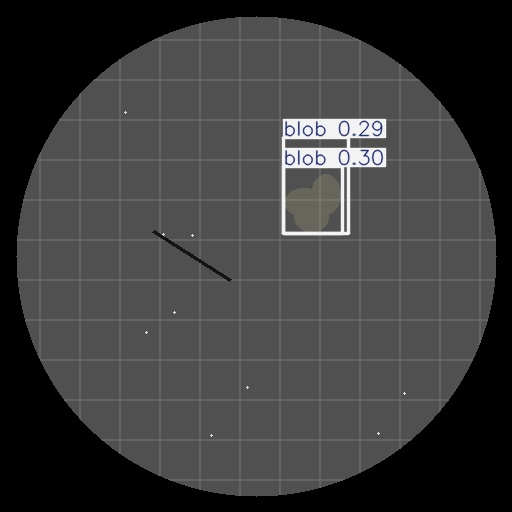


Debug result for: wafer_blob.jpg


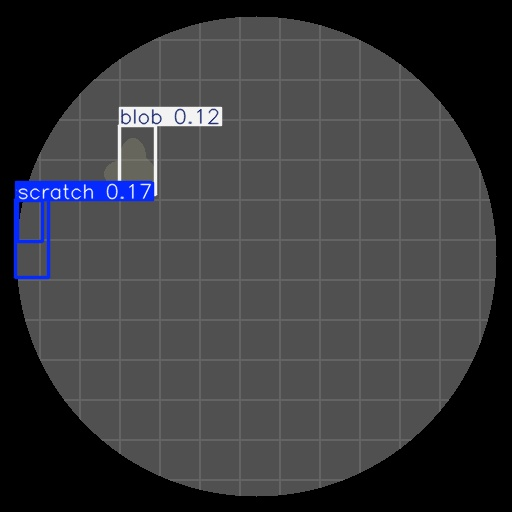


Debug result for: wafer_clean.jpg


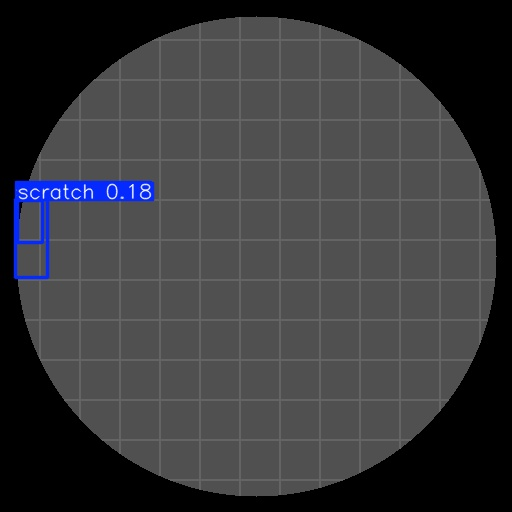


Debug result for: wafer_particles.jpg


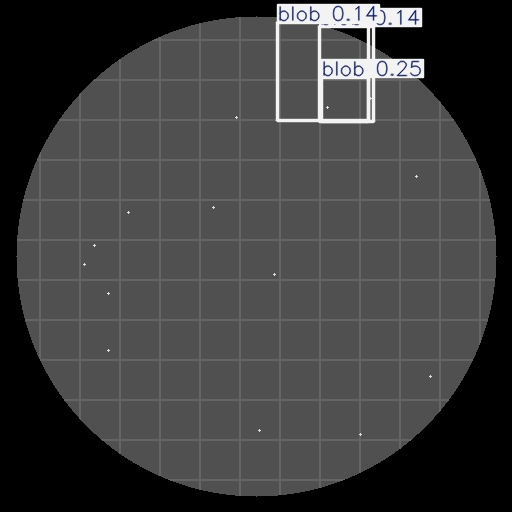


Debug result for: wafer_scratch.jpg


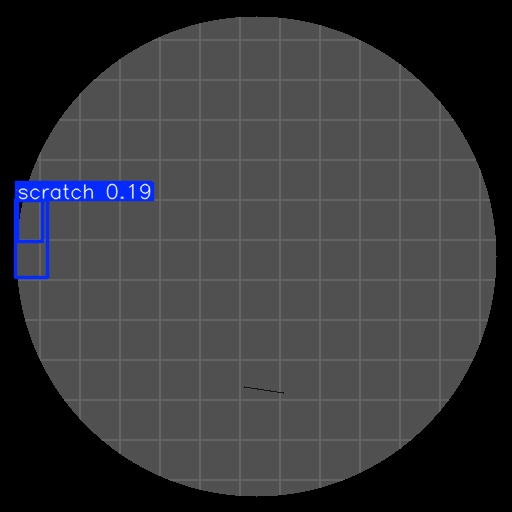

In [12]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- Final Debugging Evaluation ---

# Path to our ultimate trained model
model_path = '/content/drive/MyDrive/wafer_project/wafer_final_runs/ultimate_model_yolov8s/weights/best.pt'
test_images_folder = 'test_images_unzipped/test_images'

if not os.path.exists(model_path):
    print(f"❌ ERROR: Final model not found at {model_path}")
else:
    print(f"Loading final model from: {model_path}")
    model = YOLO(model_path)
    print("✅ Final model loaded successfully.")

    # --- CRITICAL CHANGE: Lowering confidence to see EVERYTHING the model thinks ---
    print("\n🚀 Running DEBUG predictions with conf=0.1...")
    results = model.predict(
        source=test_images_folder,
        save=True,
        conf=0.1 # <-- The only change. We are now accepting detections the model is only 10% sure about.
    )
    print("✅ Debug predictions complete!")

    prediction_output_dir = results[0].save_dir
    result_images = sorted(glob.glob(os.path.join(prediction_output_dir, '*.jpg')))

    if not result_images:
        print("\nCould not find any result images.")
    else:
        print("\n--- ✅ Debug Prediction Results ---")
        for img_path in result_images:
            print(f"\nDebug result for: {os.path.basename(img_path)}")
            display(Image(filename=img_path))

Final Data Generation Script

In [13]:
import os
import cv2
import numpy as np
import random
import shutil
import math

# --- Configuration ---
DATASET_PATH = 'ultimate_wafer_dataset'
NUM_IMAGES = 2500
IMG_WIDTH = 640
IMG_HEIGHT = 640
defect_classes = {"scratch": 0, "particle": 1, "blob": 2}

# --- Helper Functions ---

def create_base_wafer():
    """
    Creates a more realistic, textured silicon wafer background with variations
    to prevent the model from overfitting to a single background pattern.
    """
    bg_type = random.choice(['smooth', 'grainy', 'gradient'])
    base_color = random.randint(45, 60)
    image = np.full((IMG_HEIGHT, IMG_WIDTH, 3), base_color, dtype=np.uint8)

    if bg_type == 'grainy':
        noise = np.random.normal(0, 3, (IMG_HEIGHT, IMG_WIDTH, 3)).astype(np.int16)
        image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)
        image = cv2.GaussianBlur(image, (3, 3), 0)
    elif bg_type == 'gradient':
        end_color = base_color - random.randint(10, 20)
        c = np.linspace(base_color, end_color, IMG_WIDTH, dtype=np.uint8)
        image[:, :, :] = c[np.newaxis, :, np.newaxis]

    # Add a subtle color tint to mimic silicon
    tint_color = np.array([1.0, 1.0, random.uniform(1.0, 1.05)])
    image = np.clip(image * tint_color, 0, 255).astype(np.uint8)
    return image

def add_advanced_scratch(image):
    """
    Generates straight, curved, or wavy scratches to teach the model to
    differentiate from simple background lines.
    """
    start_x, start_y = random.randint(50, IMG_WIDTH - 50), random.randint(50, IMG_HEIGHT - 50)
    thickness, color = random.randint(1, 2), (random.randint(220, 255),) * 3
    points = [(start_x, start_y)]
    scratch_type = random.choice(['straight', 'curved', 'wavy'])
    if scratch_type == 'straight':
        end_x, end_y = start_x + random.randint(-200, 200), start_y + random.randint(-200, 200)
        points.append((end_x, end_y))
    elif scratch_type == 'curved':
        end_x, end_y = start_x + random.randint(-200, 200), start_y + random.randint(-200, 200)
        ctrl_x = (start_x + end_x) // 2 + random.randint(-50, 50)
        ctrl_y = (start_y + end_y) // 2 + random.randint(-50, 50)
        for i in range(1, 21):
            t = i / 20.0
            x = int((1 - t)**2 * start_x + 2 * (1 - t) * t * ctrl_x + t**2 * end_x)
            y = int((1 - t)**2 * start_y + 2 * (1 - t) * t * ctrl_y + t**2 * end_y)
            points.append((x,y))
    elif scratch_type == 'wavy':
        length, angle = random.randint(100, 300), random.uniform(0, 2 * math.pi)
        freq, amp = random.uniform(0.02, 0.05), random.uniform(5, 15)
        for i in range(length):
            x = start_x + int(i * math.cos(angle) - amp * math.sin(i * freq) * math.sin(angle))
            y = start_y + int(i * math.sin(angle) + amp * math.sin(i * freq) * math.cos(angle))
            points.append((x,y))

    for i in range(len(points) - 1):
        if 0 <= points[i][0] < IMG_WIDTH and 0 <= points[i][1] < IMG_HEIGHT and \
           0 <= points[i+1][0] < IMG_WIDTH and 0 <= points[i+1][1] < IMG_HEIGHT:
            cv2.line(image, points[i], points[i+1], color, thickness)

    all_x = [p[0] for p in points]; all_y = [p[1] for p in points]
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min

    return image, [defect_classes["scratch"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]


def add_distinct_particles(image):
    """
    Adds small, sharp, bright 'dust' specks to solve class confusion and
    improve detection of small objects.
    """
    num_particles = random.randint(1, 15)
    all_x, all_y = [], []
    for _ in range(num_particles):
        px, py = random.randint(20, IMG_WIDTH - 20), random.randint(20, IMG_HEIGHT - 20)
        radius = random.randint(1, 2)
        color = (random.randint(230, 255),) * 3
        cv2.circle(image, (px, py), radius, color, -1)
        all_x.extend([px - radius, px + radius]); all_y.extend([py - radius, py + radius])

    x_min, x_max, y_min, y_max = min(all_x), max(all_x), min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    return image, [defect_classes["particle"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

def add_distinct_blob(image):
    """
    Adds a larger, irregular, transparent 'smudge' to solve class confusion.
    """
    overlay, output = image.copy(), image.copy()
    center_x, center_y = random.randint(150, IMG_WIDTH - 150), random.randint(150, IMG_HEIGHT - 150)

    num_points = random.randint(5, 10)
    angles = sorted([random.uniform(0, 2 * math.pi) for _ in range(num_points)])
    points = []
    for angle in angles:
        radius = random.uniform(40, 80)
        x = center_x + int(radius * math.cos(angle))
        y = center_y + int(radius * math.sin(angle))
        points.append([x, y])
    points = np.array(points, np.int32)

    color = (random.randint(80, 100),) * 3
    cv2.fillPoly(overlay, [points], color)
    overlay = cv2.GaussianBlur(overlay, (21, 21), 0)

    transparency = random.uniform(0.2, 0.5)
    cv2.addWeighted(overlay, transparency, output, 1 - transparency, 0, image)

    all_x, all_y = points[:, 0], points[:, 1]
    x_min, x_max, y_min, y_max = min(all_x), max(all_x), min(all_y), max(all_y)
    x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
    width, height = x_max - x_min, y_max - y_min
    return image, [defect_classes["blob"], x_center / IMG_WIDTH, y_center / IMG_HEIGHT, width / IMG_WIDTH, height / IMG_HEIGHT]

# --- Main Generation Function ---
def generate_ultimate_dataset():
    images_path = os.path.join(DATASET_PATH, 'images')
    labels_path = os.path.join(DATASET_PATH, 'labels')
    if os.path.exists(DATASET_PATH): shutil.rmtree(DATASET_PATH)
    os.makedirs(images_path, exist_ok=True); os.makedirs(labels_path, exist_ok=True)
    print(f"Directories created at: {os.path.abspath(DATASET_PATH)}")
    for i in range(NUM_IMAGES):
        wafer_image, annotations = create_base_wafer(), []
        if random.random() >= 0.25: # 25% of images will be clean "negative" samples
            for _ in range(random.randint(1, 4)):
                defect_type = random.choice(list(defect_classes.keys()))
                if defect_type == "scratch": wafer_image, ann = add_advanced_scratch(wafer_image)
                elif defect_type == "particle": wafer_image, ann = add_distinct_particles(wafer_image)
                else: wafer_image, ann = add_distinct_blob(wafer_image)
                if ann and ann[3] > 0 and ann[4] > 0: annotations.append(ann)
        img_name, label_name = f'wafer_{i:04d}.png', f'wafer_{i:04d}.txt'
        cv2.imwrite(os.path.join(images_path, img_name), wafer_image)
        with open(os.path.join(labels_path, label_name), 'w') as f:
            for ann in annotations: f.write(f"{ann[0]} {ann[1]} {ann[2]} {ann[3]} {ann[4]}\n")
        if (i + 1) % 250 == 0: print(f"  -> Generated {i + 1}/{NUM_IMAGES} images...")
    print(f"\n✅ Ultimate dataset generation complete!")

generate_ultimate_dataset()

Directories created at: /content/ultimate_wafer_dataset
  -> Generated 250/2500 images...
  -> Generated 500/2500 images...
  -> Generated 750/2500 images...
  -> Generated 1000/2500 images...
  -> Generated 1250/2500 images...
  -> Generated 1500/2500 images...
  -> Generated 1750/2500 images...
  -> Generated 2000/2500 images...
  -> Generated 2250/2500 images...
  -> Generated 2500/2500 images...

✅ Ultimate dataset generation complete!


Split the Ultimate Dataset

In [15]:
import os
import random
import shutil

# --- Configuration ---
DATA_SOURCE_DIR = 'ultimate_wafer_dataset'
OUTPUT_DIR = 'ultimate_data_for_training'
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2

# --- Splitting Logic ---
images_source_path = os.path.join(DATA_SOURCE_DIR, 'images')
all_images = [f for f in os.listdir(images_source_path) if f.endswith('.png')]
random.shuffle(all_images)

total_images = len(all_images)
train_end = int(total_images * TRAIN_RATIO)
val_end = train_end + int(total_images * VAL_RATIO)

train_files = all_images[:train_end]
val_files = all_images[train_end:val_end]
test_files = all_images[val_end:]

def copy_files(file_list, set_name):
    dest_images_path = os.path.join(OUTPUT_DIR, set_name, 'images')
    dest_labels_path = os.path.join(OUTPUT_DIR, set_name, 'labels')
    os.makedirs(dest_images_path, exist_ok=True)
    os.makedirs(dest_labels_path, exist_ok=True)
    source_images_path = os.path.join(DATA_SOURCE_DIR, 'images')
    source_labels_path = os.path.join(DATA_SOURCE_DIR, 'labels')
    for filename in file_list:
        base_name = os.path.splitext(filename)[0]
        shutil.copy(os.path.join(source_images_path, filename), os.path.join(dest_images_path, filename))
        shutil.copy(os.path.join(source_labels_path, f'{base_name}.txt'), os.path.join(dest_labels_path, f'{base_name}.txt'))
    print(f"  -> Copied {len(file_list)} files to the '{set_name}' set.")

if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

# --- Create YAML File ---
yaml_content = f"""
path: {os.path.abspath(OUTPUT_DIR)}
train: train/images
val: val/images
test: test/images

nc: 3
names: ['scratch', 'particle', 'blob']
"""
with open(os.path.join(OUTPUT_DIR, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print(f"\n✅ Ultimate dataset successfully split.")

  -> Copied 1750 files to the 'train' set.
  -> Copied 500 files to the 'val' set.
  -> Copied 250 files to the 'test' set.

✅ Ultimate dataset successfully split.


Train the Final Model

In [16]:
from ultralytics import YOLO

# --- Load the upgraded YOLOv8s model ---
model = YOLO('yolov8s.pt')

# --- Define the Google Drive save path ---
drive_project_path = '/content/drive/MyDrive/wafer_project/wafer_final_runs'

# --- Start the final training ---
print("🚀 Starting the FINAL model training with YOLOv8s, full augmentation, and 75 epochs...")
results = model.train(
    data='ultimate_data_for_training/data.yaml',
    epochs=75,         # Increased for better learning
    imgsz=640,
    degrees=15,        # Data augmentation
    translate=0.1,
    scale=0.1,
    fliplr=0.5,
    project=drive_project_path,
    name='Silicon_Sentinel_v1.0' # Final model name
)

print("✅ FINAL training complete!")
print(f"Model and results are permanently saved in your Google Drive at: {results.save_dir}")

🚀 Starting the FINAL model training with YOLOv8s, full augmentation, and 75 epochs...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=ultimate_data_for_training/data.yaml, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=75, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Silicon_Sentinel_v1.0, nbs=64, nms=False, opset=None, optimi

train: Scanning /content/ultimate_data_for_training/train/labels... 1750 images, 439 backgrounds, 53 corrupt: 100%|██████████| 1750/1750 [00:00<00:00, 1930.32it/s]

train: /content/ultimate_data_for_training/train/images/wafer_0104.png: ignoring corrupt image/label: negative class labels [  -0.042969]
train: /content/ultimate_data_for_training/train/images/wafer_0195.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0141]
train: /content/ultimate_data_for_training/train/images/wafer_0318.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0258]
train: /content/ultimate_data_for_training/train/images/wafer_0329.png: ignoring corrupt image/label: negative class labels [  -0.069531]
train: /content/ultimate_data_for_training/train/images/wafer_0360.png: ignoring corrupt image/label: negative class labels [  -0.017188]
train: /content/ultimate_data_for_training/train/images/wafer_0362.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0391]
train: /content/ultimate_data_for_training/train/images/wafer_0426.png: ignoring corrupt image/label: non-

train: New cache created: /content/ultimate_data_for_training/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 113.8±46.4 MB/s, size: 11.1 KB)


val: Scanning /content/ultimate_data_for_training/val/labels... 500 images, 131 backgrounds, 10 corrupt: 100%|██████████| 500/500 [00:00<00:00, 835.95it/s]

val: /content/ultimate_data_for_training/val/images/wafer_0034.png: ignoring corrupt image/label: negative class labels [  -0.019531]
val: /content/ultimate_data_for_training/val/images/wafer_0337.png: ignoring corrupt image/label: negative class labels [  -0.032031]
val: /content/ultimate_data_for_training/val/images/wafer_0702.png: ignoring corrupt image/label: negative class labels [  -0.024219]
val: /content/ultimate_data_for_training/val/images/wafer_1548.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0648]
val: /content/ultimate_data_for_training/val/images/wafer_1700.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0516]
val: /content/ultimate_data_for_training/val/images/wafer_2146.png: ignoring corrupt image/label: negative class labels [  -0.032031]
val: /content/ultimate_data_for_training/val/images/wafer_2288.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.01

val: New cache created: /content/ultimate_data_for_training/val/labels.cache
Plotting labels to /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      3.99G      1.603      2.002      1.807          0        640: 100%|██████████| 107/107 [00:41<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]

                   all        490        842      0.683      0.617      0.607      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      4.75G      1.601      1.466      1.845          3        640: 100%|██████████| 107/107 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]


                   all        490        842       0.53      0.382      0.408      0.193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      4.75G      1.589      1.508      1.809          0        640: 100%|██████████| 107/107 [00:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]


                   all        490        842      0.552      0.564      0.612      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75       4.8G      1.541      1.378      1.793          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]


                   all        490        842      0.768      0.697      0.735       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      4.84G      1.529      1.326      1.776          6        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]


                   all        490        842      0.691       0.71      0.722      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      4.88G      1.524       1.32      1.775          6        640: 100%|██████████| 107/107 [00:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        490        842      0.831      0.696       0.75       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75       4.9G      1.476      1.267      1.731          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]

                   all        490        842      0.745      0.648      0.705      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      4.95G      1.448      1.312      1.707          1        640: 100%|██████████| 107/107 [00:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]

                   all        490        842      0.831      0.726      0.784      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      4.99G      1.439      1.225      1.704          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]

                   all        490        842      0.857      0.721      0.796      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      5.02G       1.42      1.244      1.693          5        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


                   all        490        842      0.845      0.732      0.784      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      5.04G      1.415      1.265      1.675          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]


                   all        490        842      0.962      0.487      0.728      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75       5.1G      1.372       1.19       1.65          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.74it/s]

                   all        490        842       0.87      0.706      0.771      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      5.13G      1.353      1.169      1.644          2        640: 100%|██████████| 107/107 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all        490        842      0.846      0.736      0.797      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      5.17G      1.339      1.119      1.628          4        640: 100%|██████████| 107/107 [00:42<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]


                   all        490        842      0.899      0.718      0.785      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      5.19G      1.305      1.169      1.606          1        640: 100%|██████████| 107/107 [00:39<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]

                   all        490        842      0.888      0.742       0.81      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      5.24G      1.299      1.135      1.598          8        640: 100%|██████████| 107/107 [00:41<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


                   all        490        842       0.89      0.753      0.812      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      5.28G      1.305      1.122        1.6          3        640: 100%|██████████| 107/107 [00:39<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]

                   all        490        842      0.861      0.743      0.798      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      5.31G      1.285      1.153      1.583          1        640: 100%|██████████| 107/107 [00:41<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]

                   all        490        842      0.881      0.755      0.825        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      5.34G       1.28      1.125       1.59          4        640: 100%|██████████| 107/107 [00:41<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]

                   all        490        842       0.87      0.783      0.822      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      5.39G      1.274      1.122      1.585          1        640: 100%|██████████| 107/107 [00:38<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


                   all        490        842       0.88      0.763      0.815      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      5.42G      1.255      1.104      1.565          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]

                   all        490        842      0.877      0.754      0.819       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      5.46G      1.243      1.158      1.558          0        640: 100%|██████████| 107/107 [00:39<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]

                   all        490        842      0.861      0.765      0.817      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      5.48G      1.229      1.092      1.559          6        640: 100%|██████████| 107/107 [00:39<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all        490        842      0.911      0.752      0.825      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      5.53G      1.218      1.068      1.535          2        640: 100%|██████████| 107/107 [00:38<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all        490        842      0.898      0.764      0.822      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      5.57G       1.22      1.077      1.538          3        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


                   all        490        842      0.839      0.729      0.797      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75       5.6G      1.195      1.054      1.536          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]

                   all        490        842      0.923      0.785      0.849      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      5.62G      1.182       1.05      1.517          4        640: 100%|██████████| 107/107 [00:42<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]

                   all        490        842      0.912      0.779       0.84      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      5.67G       1.17      1.066      1.504          1        640: 100%|██████████| 107/107 [00:42<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]

                   all        490        842      0.932       0.79      0.847      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      5.71G       1.16      1.049      1.499          4        640: 100%|██████████| 107/107 [00:41<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]

                   all        490        842      0.906      0.782      0.842      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      5.75G      1.176      1.052      1.502          2        640: 100%|██████████| 107/107 [00:40<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


                   all        490        842      0.928      0.777      0.848      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      5.77G      1.134      1.033      1.484          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]

                   all        490        842      0.923      0.774      0.836      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      5.82G      1.154      1.061      1.496          2        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]

                   all        490        842      0.925      0.797      0.855      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      5.86G      1.129      1.016      1.488          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all        490        842      0.915      0.787      0.847      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      5.89G      1.107      1.014      1.465          2        640: 100%|██████████| 107/107 [00:39<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]

                   all        490        842      0.935      0.796      0.851      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      5.92G      1.142      1.048      1.485          5        640: 100%|██████████| 107/107 [00:41<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]

                   all        490        842      0.954      0.792      0.852      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75         6G      1.112      1.034      1.474          2        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]

                   all        490        842      0.918      0.805      0.857      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      6.07G      1.124      1.018      1.477          7        640: 100%|██████████| 107/107 [00:41<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]


                   all        490        842        0.9      0.794      0.851      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      6.43G      1.111       1.01      1.476          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]

                   all        490        842      0.936      0.803      0.861      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      6.45G      1.096     0.9994      1.457          5        640: 100%|██████████| 107/107 [00:41<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all        490        842      0.914        0.8       0.86      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75       6.5G      1.106      1.013       1.47          3        640: 100%|██████████| 107/107 [00:41<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.01it/s]


                   all        490        842      0.922      0.793      0.839      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      6.54G      1.097      1.013      1.459          6        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]

                   all        490        842      0.935      0.788      0.843      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      6.57G       1.05      1.033      1.426          0        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all        490        842      0.926      0.804      0.863      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75       6.6G      1.057      1.032      1.426          0        640: 100%|██████████| 107/107 [00:41<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]

                   all        490        842        0.9      0.802      0.862      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      6.65G      1.055     0.9834      1.431          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]

                   all        490        842      0.894       0.79      0.839      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      6.68G      1.058     0.9619       1.43          6        640: 100%|██████████| 107/107 [00:39<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]

                   all        490        842      0.917      0.811      0.859      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      6.72G      1.055     0.9672       1.43          5        640: 100%|██████████| 107/107 [00:39<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]

                   all        490        842      0.942      0.803       0.86      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      6.74G      1.048     0.9707      1.433          1        640: 100%|██████████| 107/107 [00:39<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]

                   all        490        842      0.929      0.809      0.855      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      6.79G      1.039     0.9482      1.414          5        640: 100%|██████████| 107/107 [00:39<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]

                   all        490        842      0.943      0.815      0.867      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      6.86G      1.045     0.9602      1.414          3        640: 100%|██████████| 107/107 [00:42<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.59it/s]

                   all        490        842      0.929        0.8      0.856      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      6.93G      1.044     0.9614      1.428          3        640: 100%|██████████| 107/107 [00:37<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all        490        842      0.926      0.807      0.866      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      6.95G      1.021     0.9669       1.41          4        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]


                   all        490        842      0.937      0.801      0.859      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      7.07G      1.033     0.9588      1.425          5        640: 100%|██████████| 107/107 [00:40<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.18it/s]


                   all        490        842      0.962      0.781      0.851      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      7.14G      1.023     0.9585      1.422          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


                   all        490        842       0.93      0.811      0.864      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      7.17G      1.014     0.9609      1.413          2        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]

                   all        490        842       0.95      0.807      0.866      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      7.23G      1.003     0.9438      1.405          3        640: 100%|██████████| 107/107 [00:40<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]

                   all        490        842      0.924      0.823       0.87      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      7.31G     0.9861     0.9229      1.389          1        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]


                   all        490        842      0.943      0.808      0.867      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      7.38G     0.9831     0.9308      1.392          5        640: 100%|██████████| 107/107 [00:39<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


                   all        490        842      0.935      0.814      0.868      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      3.83G     0.9875     0.9422      1.389          6        640: 100%|██████████| 107/107 [00:41<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]

                   all        490        842      0.934      0.825      0.867      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      3.83G     0.9654     0.9085      1.381          3        640: 100%|██████████| 107/107 [00:40<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]

                   all        490        842      0.921      0.831      0.873      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      3.83G     0.9798     0.9304      1.385          3        640: 100%|██████████| 107/107 [00:39<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


                   all        490        842      0.925      0.813      0.863      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      3.83G     0.9536     0.8992      1.367          4        640: 100%|██████████| 107/107 [00:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.05it/s]

                   all        490        842      0.924      0.826      0.871      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      3.83G     0.9715     0.9006      1.378          5        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]

                   all        490        842      0.924      0.826       0.87      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      3.87G     0.9696     0.9033      1.379          5        640: 100%|██████████| 107/107 [00:40<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]

                   all        490        842      0.942      0.807      0.865      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      3.93G     0.9654     0.9235      1.377          1        640: 100%|██████████| 107/107 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all        490        842      0.938      0.825      0.871      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      3.93G     0.9359     0.9589      1.354          0        640: 100%|██████████| 107/107 [00:40<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.20it/s]

                   all        490        842      0.915      0.836      0.874      0.709


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      4.09G     0.8625       0.72      1.304          3        640: 100%|██████████| 107/107 [00:39<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]

                   all        490        842      0.936      0.827       0.88      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      4.11G      0.818     0.6619      1.265          4        640: 100%|██████████| 107/107 [00:37<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


                   all        490        842      0.929      0.834      0.878      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      4.16G     0.8079     0.6551      1.263          2        640: 100%|██████████| 107/107 [00:38<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]

                   all        490        842      0.942      0.822      0.873      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75       4.2G     0.7993      0.646      1.241          1        640: 100%|██████████| 107/107 [00:39<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]

                   all        490        842      0.933      0.837      0.872      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      4.27G     0.7798     0.6389      1.234          3        640: 100%|██████████| 107/107 [00:39<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]

                   all        490        842      0.943      0.831      0.875      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      4.29G     0.7707     0.6281      1.235          4        640: 100%|██████████| 107/107 [00:37<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]


                   all        490        842      0.942      0.845      0.876      0.731

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      4.41G     0.7576     0.6242      1.225          1        640: 100%|██████████| 107/107 [00:37<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]

                   all        490        842      0.933      0.849      0.875      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      4.44G     0.7561     0.6192      1.214          4        640: 100%|██████████| 107/107 [00:36<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all        490        842       0.94      0.839      0.875      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      4.51G     0.7492     0.6219      1.226          1        640: 100%|██████████| 107/107 [00:36<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all        490        842      0.941       0.84      0.876      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      4.57G     0.7311     0.6042        1.2          4        640: 100%|██████████| 107/107 [00:38<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]

                   all        490        842      0.947      0.842      0.874      0.746



75 epochs completed in 0.973 hours.
Optimizer stripped from /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt...
Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


                   all        490        842      0.946      0.842      0.875      0.746
               scratch        201        288      0.898      0.872      0.906      0.727
              particle        202        272      0.955      0.654      0.724      0.552
                  blob        212        282      0.985          1      0.995       0.96
Speed: 0.3ms preprocess, 5.1ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0
✅ FINAL training complete!
Model and results are permanently saved in your Google Drive at: /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0


Final Evaluation

Unzipping test images...
Archive:  test_images.zip
  inflating: test_images_unzipped/test_images/wafer_blob.png  
  inflating: test_images_unzipped/test_images/wafer_scratch.png  
  inflating: test_images_unzipped/test_images/wafer_all_defects.png  
  inflating: test_images_unzipped/test_images/wafer_particles.png  
  inflating: test_images_unzipped/test_images/wafer_clean.png  
✅ Unzip complete.

Loading Silicon Sentinel from: /content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt
✅ Final model loaded successfully.

🚀 Running FINAL predictions...

image 1/5 /content/test_images_unzipped/test_images/wafer_all_defects.png: 640x640 2 scratchs, 2 particles, 16.3ms
image 2/5 /content/test_images_unzipped/test_images/wafer_blob.png: 640x640 1 scratch, 16.2ms
image 3/5 /content/test_images_unzipped/test_images/wafer_clean.png: 640x640 1 scratch, 16.2ms
image 4/5 /content/test_images_unzipped/test_images/wafer_particles.png: 640x640 2 scratchs, 3 particles

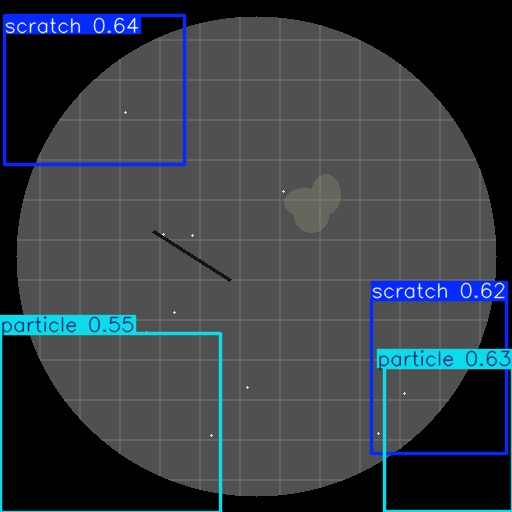


Result for: wafer_blob.jpg


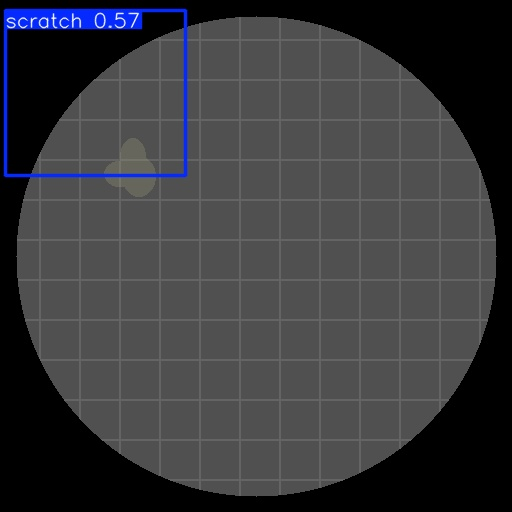


Result for: wafer_clean.jpg


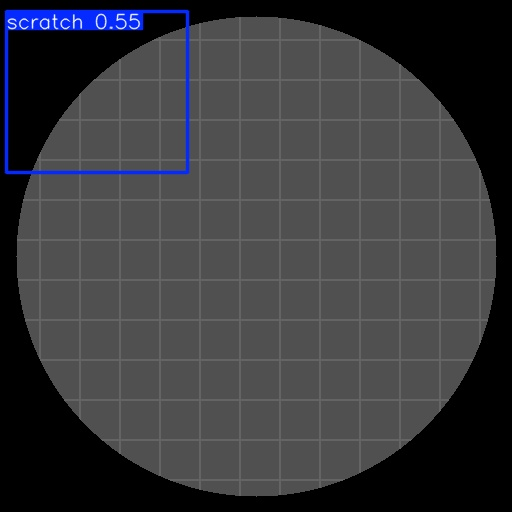


Result for: wafer_particles.jpg


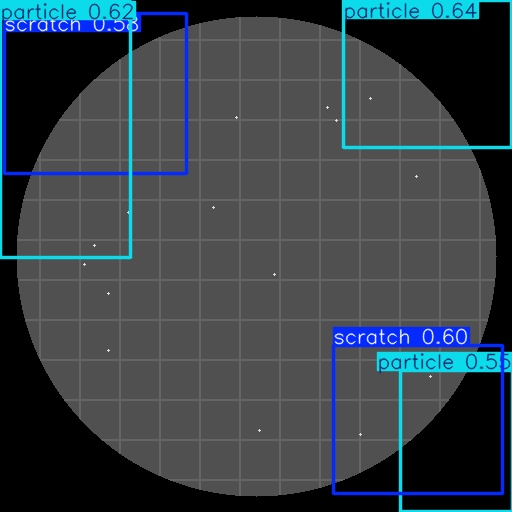


Result for: wafer_scratch.jpg


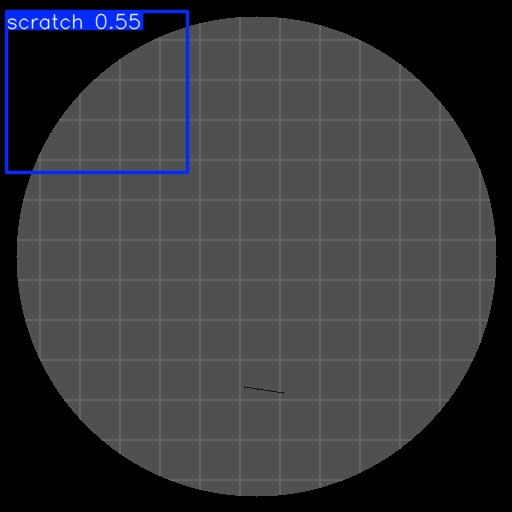

In [17]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- Unzip the test images ---
print("Unzipping test images...")
!unzip -o test_images.zip -d test_images_unzipped
print("✅ Unzip complete.")

# --- Final Model Evaluation ---

# 1. Path to our ultimate trained model in your Google Drive.
model_path = '/content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt'

# 2. Path to the test images folder.
test_images_folder = 'test_images_unzipped/test_images'

# 3. Load our final, powerful model.
print(f"\nLoading Silicon Sentinel from: {model_path}")
model = YOLO(model_path)
print("✅ Final model loaded successfully.")

# 4. Run prediction with our strict 0.5 confidence threshold.
print("\n🚀 Running FINAL predictions...")
results = model.predict(
    source=test_images_folder,
    save=True,
    conf=0.5
)
print("✅ Final predictions complete!")

# 5. Display the definitive results.
prediction_output_dir = results[0].save_dir
result_images = sorted(glob.glob(os.path.join(prediction_output_dir, '*.jpg')))

if not result_images:
    print("\nCould not find any result images.")
else:
    print("\n--- ✅ SILICON SENTINEL: FINAL RESULTS ---")
    for img_path in result_images:
        print(f"\nResult for: {os.path.basename(img_path)}")
        display(Image(filename=img_path))

In [20]:
import os
import glob
from ultralytics import YOLO
from IPython.display import Image, display

# --- Final Showcase Generation ---
print("This is the final run. We will generate several sets of results for you to choose from.")

# The path to the ULTIMATE model, which is safely in your Google Drive
model_path = '/content/drive/MyDrive/wafer_project/wafer_final_runs/Silicon_Sentinel_v1.0/weights/best.pt'
test_images_folder = 'test_images_unzipped/test_images'

if not os.path.exists(model_path):
    print(f"❌ ERROR: The final model was not found in your Google Drive at {model_path}")
else:
    model = YOLO(model_path)

    # We will test at three different confidence levels
    confidence_levels = [0.40, 0.25, 0.15]

    for conf in confidence_levels:
        print(f"\n🚀 Running prediction with confidence threshold = {conf}...")
        model.predict(
            source=test_images_folder,
            save=True,
            conf=conf,
            name=f"predict_at_{int(conf*100)}" # Saves to a unique folder like 'predict_at_25'
        )
        print(f"✅ Prediction run for conf={conf} complete!")

print("\n--- All showcase images have been generated. ---")
print("Please check the folders in 'runs/detect/' (e.g., 'predict_at_40', 'predict_at_25') to find your images.")

This is the final run. We will generate several sets of results for you to choose from.

🚀 Running prediction with confidence threshold = 0.4...

image 1/5 /content/test_images_unzipped/test_images/wafer_all_defects.png: 640x640 3 scratchs, 2 particles, 16.2ms
image 2/5 /content/test_images_unzipped/test_images/wafer_blob.png: 640x640 3 scratchs, 16.3ms
image 3/5 /content/test_images_unzipped/test_images/wafer_clean.png: 640x640 3 scratchs, 16.3ms
image 4/5 /content/test_images_unzipped/test_images/wafer_particles.png: 640x640 3 scratchs, 4 particles, 16.2ms
image 5/5 /content/test_images_unzipped/test_images/wafer_scratch.png: 640x640 3 scratchs, 16.3ms
Speed: 2.8ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict_at_40
✅ Prediction run for conf=0.4 complete!

🚀 Running prediction with confidence threshold = 0.25...

image 1/5 /content/test_images_unzipped/test_images/wafer_all_defects.png: 640x640 8 scratchs, 2 p